<a href="https://colab.research.google.com/github/akimotolab/Policy_Optimization_Tutorial/blob/main/2_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 方策最適化イントロダクション

この資料では，方策最適化というものの最適化問題を数値実験を通して理解してもらうことを目的としています．
Gymnasiumと呼ばれるシミュレーション環境を用いて，実際に方策を人手で最適化したり，最適化アルゴリズムを用いて最適化する経験を通して，方策最適化を理解します．
そのため，理論的な説明は大部分割愛してあります．
理論的な部分に興味がある方は，以下の文献などを参考にしてください．

Richard S. Sutton and Andrew G. Barto, Reinforcement Learning: An Introduction, 2nd ed., The MIT Press. (2020) http://incompleteideas.net/book/RLbook2020trimmed.pdf

## Google Colab上でGymnasiumを利用する準備

以下では，必要なパッケージのインストールとインポート，仮想displayの設定を実行しています．
手元の環境でGymnasiumを利用する場合には特に難しいことはありませんが，ノートブックで実行する場合には仮想的なdisplayを設定することが必要になるなど，少し面倒です．


In [1]:
# 必要なパッケージのインストール
!apt update
!pip install swig
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gymnasium[box2d]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,461 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,008 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.

仮想ディスプレイとGPUの設定

In [2]:
from pyvirtualdisplay import Display
import torch

# 仮想ディスプレイの設定
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

必要なパッケージをインポート

In [3]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import gymnasium as gym
from IPython import display

## 方策最適化とは

まずは方策最適化に触れてみましょう．
ここでは，Cart Pole環境における方策最適化を実際に行ってみます．

この環境では，
カート上のポールを垂直上向きに保ち続けることが目標となります．
この目標を表現するために，角度が-12度から12度の間であれば報酬1が得られるようになっています．
角度がこの範囲から外れたとき，そこで実行が終了されます（terminated フラグが Trueになる）．すなわち，報酬の総和がポールを保ち続けたステップ数，ということになります．

取れる行動は，カートを右側にpushする（行動 1）か，左側にpushする（行動 0）かの二択になります．
与えられる力は自動的に定まります．

適切な行動を設計するには，現在の状態を観測する必要があります．
観測は以下の4つの情報からなる実数値ベクトルです．

1. cart position
2. cart velocity
3. pole angle
4. pole angular velocity

それぞれの範囲については，以下のURLを確認してください．

https://gymnasium.farama.org/environments/classic_control/cart_pole/

観測状態に応じて行動を決定するルールが方策です．

以下で定義する`rollout`関数は，与えられた方策を用いて，現在の状態を観測し，この観測に基づいて方策が行動選択し，この行動を実際に実行することで次の状態に遷移する，というプロセスを繰り返しています．

`visualize`関数は，`rollout`の結果をアニメーションとして可視化する関数です．

`cumulative_reward`関数は，`rollout`の結果から方策の望ましさを示す指標値を計算します．
大きいほどよい方策ということになります．



In [15]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []

    # 乱数の設定
    if seed is not None:
        random.seed(seed)
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)

    # 可視化用の設定
    if render:
        d = Display()
        d.start()
        img.append(env.render())

    # メインループ（環境とのインタラクション）
    terminated = False
    truncated = False
    while not (terminated or truncated):

        # 行動を選択
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)

        # 行動を実行
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        observation = next_observation
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

上のコードにおいて重要な箇所を解説します．

observation, info = env.reset(seed=...) : 状態を初期化しています．observationが初期の状態，infoは環境固有の情報を含んでいます．初期状態はランダムにきまるため，そのシードがseed=..で指定されています．このシードが固定されていると，毎回同じ用に初期化されることになります．

action = policy(observation) : 現在の状態の観測値 observation に従って，方策により行動 action を選択します．

observation, reward, terminated, truncated, info = env.step(action) : 行動 action を実行し，次の状態の観測値 observation，即時報酬 reward，終了状態に達したことを表すフラグ terminated，最大ステップ数に達したことを表すフラグtruncated，その他の情報 infoを返します．

## ランダム方策を用いてインタラクションしてみる

それではまず，取りうる行動の範囲からランダムに行動を選択するランダム方策を用いて，実際に環境とインタラクションしてみましょう．
先程定義した`rollout`関数では，`policy`を引数に与えない場合，ランダム方策を用いるように定義されています．
それでは以下を実行してみましょう．

すぐに倒れてしまう様子が確認できると思います．
ランダムに行動を選択しているということは，ポールの状態を考えずにサイコロで行動を決定しているということになりますから，当然ですね．



In [ ]:
envname = "CartPole-v1"
history, img = rollout(envname, render=True)  # 可視化する場合には render = True
visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

## 方策を手作りしてみる

ここでは，自分で方策を作成してみましょう．

簡単に思いつく方法としては，

- ポールが右側に倒れていれば（角度が正の値）ならば，右側にカートを押す（行動 1）
- ポールが左側に倒れていれば（角度が負の値）ならば，左側にカートを押す（行動 0）

かと思います．
これをまずは試してみましょう．

`rollout`では，方策は観測`observation`を受け取って行動を返すcallableであることを想定しています．
ここでは関数として定義します．（後にクラスとして定義します．）

In [ ]:
def manual_policy(observation):
    # observation[2] が角度．負は左側に傾いている
    if observation[2] < 0:
        return 0
    else:
        return 1

この方策に従って行動した場合，どの程度ポールが立ち続けていられるのか，確認してみましょう．
最後にプリントされる`cumulative_reward`の値がここではポールを指定された角度に保ち続けていられたステップ数です．

In [ ]:
envname = "CartPole-v1"
history, img = rollout(envname, policy=manual_policy, render=True)  # 可視化する場合には render = True
visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

ランダム行動の場合よりは少し長くポールを保てる用になっているかと思います．
ただし，ポールの振れ幅がどんどん大きくなってしまっていることが観察されるはずです．
これは，ポールの速度に関する情報や，カートの速度の情報を無視していることが原因と考えられます．

そこで，ポールの速度も用いて行動選択をしてみましょう．
ここでは，まずポールの角度を用いて条件分け，その後ポールの角速度を用いて条件分け，という手続きで行動選択することを考えましょう．
上のケースと同じように，ポールが左に傾いていれば，左側に押すことが自然です．
その際，角速度が負であるか，もしくは正の小さな値であれば，左側に押すことで，角速度を正側に大きくすることになるため，やはり左側に押すことが適切であるように思います．
他方，ポールが左に傾いていても，角速度が正の大きな値であるならば，押さなくても自然にポールは垂直方向に変化します．
逆に，ポールの角速度を小さくするほうが，安定して垂直に保てると考えられます．
右側に傾いている場合にも，上と同様に考えられます．

そこで，下に定義するような方策を考えてみましょう．

1. $\theta < 0$かつ$\dot{\theta} < U$ならば左に押す（行動0）
2. $\theta < 0$かつ$\dot{\theta} \geq U$ならば右に押す（行動1）
1. $\theta \geq 0$かつ$\dot{\theta} > L$ならば右に押す（行動1）
2. $\theta \geq 0$かつ$\dot{\theta} \leq L$ならば左に押す（行動0）

ここで，$U$や$L$はパラメータです．
上の議論から，$U > 0$，$L < 0$となることが自然です．
なお，`manual_policy`は，$U = \infty$，$L = -\infty$であるケースに該当していることがわかるかと思います．

以下のコードにおいて，$L$や$U$を変更し，長い間（最大500ステップ）ポールを垂直に保つように試行錯誤してみましょう．

In [ ]:
import numpy as np
def manual_policy2(observation):
    U = np.infty
    L = - np.infty
    if observation[2] < 0:
        if observation[3] < U:
            return 0
        else:
            return 1
    else:
        if observation[3] > L:
            return 1
        else:
            return 0

試行錯誤をしている間は，動画は作成する必要ありません．
`cumulative_reward` の返り値を最大（500）にするように，$L$と$U$を変更しましょう．
動作を確認したいときは，コメントアウトを外して動画を作成しましょう．

In [ ]:
envname = "CartPole-v1"
history, img = rollout(envname, policy=manual_policy2, render=True)  # 可視化する場合には render = True
# visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

以下，良い方策を示しているのでわざと空白を入れています．
自分で試行錯誤してから先に進みましょう．

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.



$L = -0.1$，$U = 0.1$などと設定すると，500ステップずっとポールを保ち続けることができます．

In [ ]:
import numpy as np
def manual_policy3(observation):
    U = 0.1
    L = - 0.1
    if observation[2] < 0:
        if observation[3] < U:
            return 0
        else:
            return 1
    else:
        if observation[3] > L:
            return 1
        else:
            return 0

In [ ]:
envname = "CartPole-v1"
history, img = rollout(envname, policy=manual_policy3, render=True)  # 可視化する場合には render = True
visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

さて，今実際に行ってみたように，$L$や$U$を変えるとそれによって方策が定まり，その結果得られる累積報酬が変化しました．
このように，累積報酬を最大にするような方策を見つけ出すことこそが方策最適化です．
$L$や$U$は方策を表現するためのパラメータです．
基本的には，方策は何らかの方法（ここでは決定木と呼ばれるもの）で表現され，それはパラメータを持つことになります．
方策最適化は，このパラメータを最適化することで，得られる累積報酬を最大化します．

# ブラックボックス最適化アルゴリズムを用いた方策の直接探索
上に見た CartPole 環境では行動が $\{0, 1\}$ の離散値であり，少し考えればうまく動く単純な方策を人が容易に設計できました．
一般的にはそう簡単には良い方策を人手で設計することはできません．
例えば，行動が連続値である場合には，そう簡単にうまく行かないかもしれません．
その場合，方策最適化問題を，最適化アルゴリズムを用いて実現する方法が考えられます．
ここではその一例を見てみましょう．

## 使用環境１：Pendulum（連続状態，連続行動）
ここでは，Pendulum環境を用いて方策最適化問題の例を見ていきます．
環境については，以下のURLで説明されています．

https://gymnasium.farama.org/environments/classic_control/pendulum/

ランダムに初期化されたpendulumの角度を，垂直上向きに振り上げて保ち続けることが目標となります．
観測状態は角度$\theta$に対して，

1. $\cos(\theta) \in [-1, 1]$
2. $\sin(\theta) \in [-1, 1]$
3. $\dot\theta \in [-8, 8]$

となっており，行動はpendulumに対するトルクです．
以下，ランダム行動を取る場合の振る舞いです．
報酬は負の値であり，各ステップ$[-16.2736044, 0]$の報酬が与えられます．
200ステップ分の累積が大きくなる，すなわち$0$に近いほど，良い方策であると言えます．

In [ ]:
envname = "Pendulum-v1"
history, img = rollout(envname, render=True)  # 可視化する場合には render = True
visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

ランダム行動だと-1000を下回る程度の累積報酬になってしまっていることがわかるかと思います．

## 線形モデルによる方策の表現

それでは方策を最適化することを考えていきましょう．
まず，最適化対象となる方策をモデル化する必要があります．
ここでは簡単のため，線形モデルを考えましょう．

観測 `observation` は三次元のベクトルであり，値は$[-1, 1] \times [-1, 1] \times [-8, 8]$です．
簡単のため，これをベクトル$\mathbf{x} = (x_1, x_2, x_3)$ と書きます．
行動$a$は一次元の値であるため，これを
$$
a = \mathbf{w}^\mathrm{T} \mathbf{x} = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3
$$
と決定する方策を考えましょう．
このとき，最適化対象は四次元ベクトル$\mathbf{w} = (w_0, w_1, w_2, w_3)$です．






In [ ]:
class LinearPolicy:
    def __init__(self, weights):
        self.weights = weights
    def __call__(self, observation):
        return np.array([self.weights[0] + np.dot(observation, self.weights[1:4])])

## 目的関数の定義

最適化問題としてアプローチするために，目的関数を定義します．
ここでの目的は累積報酬を最大化することです．
そのため，目的関数$J(\mathbf{w})$を，パラメータ$\mathbf{w}$の線形方策を用いて得られる累積報酬としましょう．

この目的関数を$\mathbf{w}$の関数として書き下すことは，状態遷移確率や報酬関数を知らない限りできません．
そこで，与えられたパラメータ$\mathbf{w}$を用いた線形方策を用い，実際に環境とのインタラクションを通して目的関数の値を計算します．

以下で，この目的関数の値を計算する関数を定義しています．
本来，方策最適化の目的は，任意の初期状態から得られる累積報酬を最大にするような方策を獲得することですが，ここでは簡単のため，初期状態は固定（環境を特定のシードで初期化）することを考えます．
中身は，これまでに実施してきたメインループそのものとなっています．
また，最適化アルゴリズムは多くの場合，最小化問題を想定しているので，目的関数を$-1$倍することにします．

In [ ]:
envname = "Pendulum-v1"
dim_state = 3
dim_action = 1
dim_x = dim_state + 1


def objective(x):
    policy = LinearPolicy(x)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history)

適当な値を入れてみましょう．
シードを固定しているので，同じパラメータを入力すれば，何度計算しても同じ値が帰ってくるはずです．

In [ ]:
objective(np.array([0, 0, 0, 0]))

## (1+1)-ES による最適化

ブラックボックス最適化アプローチである，(1+1)-ESを用いて最適化してみましょう．
多くの数値最適化法では，目的関数の勾配を利用します．
しかし，今回の問題では，目的関数の勾配を得ることが自明でないと容易にわかるかと思います．
(1+1)-ESは，勾配を使わず，目的関数の大小関係のみを用いて探索する方法であるため，非常に適用範囲の広いアプローチです．

In [ ]:
class ES:
    def __init__(self, init_s, init_x, init_fx):
        self.fx = init_fx
        self.x = np.array(init_x, copy=True)
        self.s = init_s
        self.dim = len(self.x)
        self.alpha = np.exp(1.0 / self.dim)
        self.y = np.empty(self.dim)

    def ask(self):
        # N(x, s^2 * I) により，新しい解の候補を生成
        self.y = self.x + self.s * np.random.randn(self.dim)
        return self.y

    def tell(self, fx):
        # x と s の更新
        if self.fx < fx:
            # 生成された解が x よりも望ましく無い場合， s を小さくする（探索の幅を狭める）
            self.s /= self.alpha**(0.25)
        else:
            # 生成された解が x よりも望ましい場合， s を大きくする（探索の幅を広める）とともに，xを生成された解で上書き
            self.s *= self.alpha
            self.x = self.y
            self.fx = fx

In [ ]:
# 初期分布の設計
sigma = 4.0
mean = np.ones(4)

# 履歴
f_hist = np.empty(1000)
f_hist[0] = objective(mean)

# 実行
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()  # 新しい解を生成
    f_hist[t] = objective(w)  # 新しい解を評価
    es.tell(f_hist[t])  # 分布を更新

探索過程で得られた解の評価値をプロットします．

In [ ]:
plt.plot(f_hist)

最終的に得られた解（線形方策のパラメータ）を見てみましょう．

In [ ]:
weights = es.x
print(weights)

最後に振る舞いを可視化してみます．

In [ ]:
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
history, img = rollout(envname, policy=policy, render=True, seed=100)  # 可視化する場合には render = True
visualize(img)  # 可視化
print(cumulative_reward(history))  # 累積報酬

(1+1)-ESは乱数を用いた最適化法ですので，試行毎に得られる解が変わります．
うまくいくと-100くらいの累積報酬が得られることが確認できます．

## 汎化性能の評価

さて，上の最適化の際には，pendulumの初期状態を固定して方策パラメータを最適化しました．
実際には，他の初期状態から始めたとしても良い方策となって欲しいので，初期値がランダムに決まるケースでの累積報酬の期待値を計算してみましょう．
期待値を計算するといっても，解析的に計算できるわけではないので，複数回ランダムな初期値から実行し，その平均を計算してみます．

以下では，与えた回数だけ累積報酬を計算（エピソードを回し）し，その結果（配列）を計算しています．

In [ ]:
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

経験分布関数をプロットしてみましょう．
ここで表示しているものは，横軸（累積報酬 x -1の値 = 目的関数の値）より小さな目的関数値が得られた割合です．
例えば，縦軸が0.5のときの横軸の値が，得られた目的関数値の中央値となります．

In [ ]:
sns.ecdfplot(data=-return_array)

この結果を見ると，特定の初期値からの方策を最適化しただけでは，他の初期値から始めた場合に最適な行動が取れていないことがわかります．
目的関数が特定の初期値からの方策の性能を評価しているため，他の初期値から始めた場合の性能を考慮していないことが一因です．

## 目的関数の再検討

最適化法は目的関数の値を良くすることだけを目標に最適なパラメータを求めていくため，使用者が望ましいと考える方策の性質を実現するためには，そのような性質をもつ方策に対してインセンティブを与えるような目的関数が設計されていることが必要です．
今回の場合，様々な初期値から始めたとしても高速にpendulumを振り上げて安定化させることが目的ですから，これを評価するような目的関数を設計する必要があります．

### 中央値の最適化
そこで，目的関数を，初期値を変えて20回方策を評価した際の中央値，としてみましょう．
このようにすることで，半分くらいは良い報酬が得られるような方策を獲得できると期待されます．
なお，目的関数の内部で計算するエピソード数が増えるほど，計算時間が増えていきますので，注意してください．

In [ ]:
import numpy as np

def objective2(weights):
    envname = "Pendulum-v1"
    policy = LinearPolicy(weights)
    seed_array = np.arange(100, 2100, 100)
    return_array = np.zeros(len(seed_array))
    for i, seed in enumerate(seed_array):
        history, img = rollout(envname, policy=policy, render=False, seed=seed)
        return_array[i] = cumulative_reward(history)
    return np.percentile(- return_array, 50)

sigma = 4.0
mean = np.ones(4)
f_hist = np.empty(500)
f_hist[0] = objective2(mean)
es2 = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es2.ask()
    f_hist[t] = objective2(w)
    es2.tell(f_hist[t])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f_hist)

In [ ]:
weights = es2.x
print(weights)

In [ ]:
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(0, 1800)
plt.grid()

こちらも，試行によって結果は変わるかと思いますが，うまく行くと報酬の中央値が-100付近の値ととるような方策が獲得できます．
すなわち，2回に1回は非常にうまくpendulumを垂直上向きに保つことができるような方策が得られるということです．
しかし，たとえば75パーセンタイル（縦軸が0.75となるときの目的関数値）は最適化の対象となっていないため，あまり低い値にならないことが確認できると思います．
このように，最適化法は，与えられた目的関数が計算する値については最適化するものの，そこに反映されていない人が暗黙に期待するような振る舞いを獲得してくれるわけではありません．

以下で振る舞いを確認してみましょう．
環境を初期化する際に乱数のシードを指定しなければ，毎回異なる初期値に初期化されます．
以下を何度か繰り返し，うまくいく試行，いかない試行の振る舞いを見てみましょう．

In [ ]:
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
history, img = rollout(envname, policy=policy, render=True)
cumulative_reward(history)
visualize(img)

### 第三四分位数の最適化

中央値の最適化では，全試行のうちうまくいく半分の試行での性能を最大化することが目的となっています．
そのため，半分よりしたの試行においての性能は著しく悪化することがあります．
もう少し高い割合で高い性能を示すような方策がほしいと思えば，目的関数を75パーセンタイルなどに変更することも可能です．
これを試してみましょう．

In [ ]:
def objective3(weights):
    envname = "Pendulum-v1"
    policy = LinearPolicy(weights)
    seed_array = np.arange(100, 2100, 100)
    return_array = np.zeros(len(seed_array))
    for i, seed in enumerate(seed_array):
        history, img = rollout(envname, policy=policy, render=False, seed=seed)
        return_array[i] = cumulative_reward(history)
    return np.percentile(- return_array, 75)

sigma = 4.0
mean = np.ones(4)
f_hist = np.empty(500)
f_hist[0] = objective3(mean)
es3 = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es3.ask()
    f_hist[t] = objective3(w)
    es3.tell(f_hist[t])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f_hist)

In [ ]:
weights = es3.x
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(0, 1800)
plt.grid()

目的関数を 75パーセンタイルに変更した場合，75パーセンタイルの値そのものは50パーセンタイルを目的関数とした場合よりも良くなっているかもしれませんが，あまり望ましい目的関数値とはなっていないことが観測されるのではないかと思います．
一つの原因として，方策の表現能力が低いため，色々な状況で望ましい振る舞いを取るような方策を表現できないことが考えられます．

## 方策表現の再検討

線形方策は単純なため，理解しやすいですが，表現能力が不足していました．
そこで，これを一般化したニューラルネットワークによる方策の表現方法を考えましょう．
ここでは一例として，`softmax`関数を用いた２層のニューラルネットワークを考えることにします．

### Softmax関数を用いたニューラルネットワークによる方策表現
ここでは，行動を以下のように決定するニューラルネットワークを考えます．
$$
a = \mathbf{V} \cdot \mathrm{softmax}\left( \mathbf{W} \cdot \mathbf{x} + \mathbf{b}\right)
$$
一般的な説明をするために，状態の次元数を$N_s$（ここでは$N_s = 3$），行動に次元数を$N_a$（ここでは$N_a = 1$）と書くことにします．
最適化対象のパラメータは$\mathbf{b} \in R^K$，$\mathbf{W} \in R^{K \times N_s}$，$\mathbf{V} \in R^{N_a \times K}$の３つであり，合計$K (1 + N_s + N_a)$個のパラメータからなります．

この方策の意味を少し考えておきましょう．
$\mathrm{softmax}$は入力ベクトル$\mathbf{y} = [y_1, \dots, y_n]$に対して
$$
\mathrm{softmax}(\mathbf{y}) = \frac{[\exp(y_1), \dots, \exp(y_n)]}{\sum_{i=1}^{n} \exp(y_i)}
$$
を計算する関数です．
出力は必ず正で和が$1$になるようなベクトルです．
名前の通り，$\max$を近似するような関数です．
上の方策の式において，$\mathrm{softmax}$の出力を$\mathbf{z}$などと書けば，行動は$\mathbf{V} = [\mathbf{v}_1 \dots \mathbf{v}_K]$ の列ベクトル$\mathbf{v}_k$の線形補間
$$
\mathbf{a} = \mathbf{V} \cdot \mathbf{z} = \sum_{k=1}^{K} z_k \mathbf{v}_k
$$
で決まります．
$\mathrm{softmax}$関数が$\max$の近似であることを考慮すれば，

* $\mathbf{V} = [\mathbf{v}_1 \dots \mathbf{v}_K]$ が取る行動の候補$K$個を定める部分

* $ \mathbf{W} \cdot \mathbf{x} + \mathbf{b}$ がどの行動を選択するかを決める部分

であることがわかります．
これは，状態空間をボロノイ分割し（分割方法は$\mathbf{W}$と$\mathbf{b}$を最適化することで変化する），各領域で選択する行動が$\mathbf{v}_k$で定まる，と解釈されます．
実際には，$\max$ではなく$\mathrm{softmax}$であるため，その間の区間を線形補間していることになります．



In [ ]:
from scipy.special import softmax

class NNPolicy:
    def __init__(self, weights):
        Na = 1
        Ns = 3
        K = 5
        self.B = weights[:K]
        self.W = weights[K:K*Ns+K].reshape((K, Ns))
        self.V = weights[K*Ns+K:K*Ns+K+K*Na].reshape((Na, K))

    def __call__(self, observation):
        z = np.dot(observation, self.W.T)
        z += self.B
        z = softmax(z)
        z = np.dot(z, self.V.T)
        return z

それではこの方策を用いて，先程は良い方策が獲得できなかった 75 パーセンタイルについて，最適化してみましょう．
最適化対象のパラメータ数が25個に増えたので，最適化のためには先程よりも少し長いイテレーションが必要となります．

In [ ]:
N = (1 + 3 + 1) * 5

def objective4(weights):
    envname = "Pendulum-v1"
    policy = NNPolicy(weights)
    seed_array = np.arange(100, 2100, 100)
    return_array = np.zeros(len(seed_array))
    for i, seed in enumerate(seed_array):
        history, img = rollout(envname, policy=policy, render=False, seed=seed)
        return_array[i] = cumulative_reward(history)
    return np.percentile(- return_array, 75)

sigma = 4.0
mean = np.ones(N)
f_hist = np.empty(1000)
f_hist[0] = objective4(mean)
es4 = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es4.ask()
    f_hist[t] = objective4(w)
    es4.tell(f_hist[t])
    if t % 10 == 0:
        print(t, np.min(f_hist[:t]))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f_hist)

In [ ]:
weights = es4.x
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(0, 1800)
plt.grid()

線形方策を用いた場合と比較して，75パーセンタイルでの目的関数値は改善しているのではないかと思います．
実際に何度か下のコードを実行して確認してみましょう．

In [ ]:
envname = "Pendulum-v1"
policy = LinearPolicy(weights)
history, img = rollout(envname, policy=policy, render=True)
cumulative_reward(history)
visualize(img)

## 使用環境２：Lunar Lander（連続状態，連続行動）

もう一つ，別の環境での例を見てみましょう．
次に扱うのは Lunar Lander 環境です．

https://gymnasium.farama.org/environments/box2d/lunar_lander/

この環境では，エージェントが$8$次元のセンサー情報（連続値）を状態として観測し，$4$つの行動から一つを選択します．
その行動は

0. 何もしない
1. 左向きのエンジンを蒸す
2. メインエンジンを蒸す
3. 右向きのエンジンを蒸す

というものです．
すなわち，先程とは異なり，行動が離散値（カテゴリカル）を取ります．

まずは以下を実行し，ランダム行動を取る場合の振る舞いを確認してみましょう．

In [ ]:
history, img = rollout("LunarLander-v2", render=True)
cumulative_reward(history)
visualize(img)

行動が連続か離散かという違いの他に，もう一点，重要な違いが PendulumとLunar Landerの間に存在します．

* Pendulum 環境やCart-Pole環境では，予め定められた回数（200回, 500回）のインタラクションを実行すると， フラグ truncated が Trueとなり，状態が初期化されます．

* Lunar Lander環境では，着陸に成功 or 着地失敗など，特定の状態になると，成功 or 失敗という認識になり，フラグterminated がTrueとなり，状態が初期化されます．

前者の場合，例えば目的関数を計算する都合上，無限に長いインタラクション数を取ることはできないため，強制的に終了させているとみなせます．
他方，後者の場合には，明確に終了となる状態が定義されており，「一度の試行」という概念が定義されているようなタスクであると言えます．
後者のようなタスクを「エピソディックタスク」と呼びます．
この二つの違いは，強化学習を行う上では重要な違い（使用できる方法に違いが生じる）であるため，認識しておきましょう．
ただ，ブラックボックス最適化として考える場合には，大きな差はありません．


### Softmax方策

行動が離散ですので，先程とは異なる方策が必要になります．
行動が4種類であるということは，状態空間を4分割し，各分割では一つの行動を選択るという方法が考えられます．
これは，教師あり学習で言うところの分類タスクに該当します．
そこで，分類タスクによく使われるSoftmaxを用いた方策を利用しましょう．
これは，$4$次元出力の線形モデルに対し，softmax関数を適用し，その結果として得られるベクトルを確率ベクトルとして行動を選択する，という確率的方策になります．

ここでも違いが出てきたので紹介しておきます．
Pendulum環境で用いていた方策はいずれも状態が与えられると行動が一意に定まる「決定的方策」でした．
他方，ここで用いている方策は，状態が与えられるとそれによって得られる条件付き確率に従って行動を選択する「確率的方策」になります．
強化学習の場合，良い行動を探索するために確率的方策が必要になる場合があります．
一方，ブラックボックス最適化として扱う場合には，探索は探索法が担っているので，確率的方策を使用することは必要ではありません．
ここでは，確率的方策の紹介と，分類タスクとの関連を紹介するために，利用しています．

Softmax方策において各行動を取る確率は以下のように定義されます．
$$
\pi(a=k \mid s) = \frac{ \exp( \mathbf{w}_k^\mathrm{T} s + b_k) }{ \sum_{i=1}^{4} \exp( \mathbf{w}_i^\mathrm{T} s + b_i) }
$$
ここで，$\mathbf{w}_1 = \mathbf{0}$と$b_1 = 0$はいずれも固定とします．
そのようにしても，表現能力は損なわれません．
逆に，全てのパラメータを変動できるようにした場合，方策がオーバーパラメタライズされた状況となり，「パラメータを変えても表現される方策が変わらず，その結果目的関数が変化しない」ような領域が無数に存在することになり，これが最適化を難しくすることがあります．
結果として，この方策はパラメータ$\theta = (\mathbf{w}_2, \mathbf{w}_3, \mathbf{w}_4, b_2, b_3, b_4)$で表現されることになります．これが最適化の対象となります．


In [ ]:
class SoftmaxPolicy:
    def __init__(self, x):
        num_action = 4
        dim_state = 8
        self.w = np.zeros((num_action, dim_state))
        self.b = np.zeros(num_action)
        self.b[1:] = x[:num_action-1]
        self.w[1:, :] = x[num_action-1:].reshape((num_action - 1, dim_state))

    def __call__(self, observation):
        logit = np.dot(self.w, observation) + self.b
        prob = softmax(logit)
        return random.choices(list(range(len(prob))), prob)[0]

それでは，このSoftmax方策を(1+1)-ESを用いて最適化してみましょう．

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)


def objective(x):
    policy = SoftmaxPolicy(x)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history)


sigma = 1.0
mean = np.zeros(dim_x)
f_hist = np.empty(2000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])

In [ ]:
weights = es.x
policy = SoftmaxPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(-400, 400)
plt.grid()

In [ ]:
history, img = rollout(envname, policy=policy, render=True)
print(cumulative_reward(history))
visualize(img)

中央値を最適化する場合についても載せておきます．

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)


def objective(weights):
    policy = SoftmaxPolicy(weights)
    seed_array = np.arange(100, 2100, 100)
    return_array = np.zeros(len(seed_array))
    for i, seed in enumerate(seed_array):
        history, img = rollout(envname, policy=policy, render=False, seed=seed)
        return_array[i] = cumulative_reward(history)
    return np.percentile(- return_array, 50)


sigma = 1.0
mean = np.ones(dim_x)
f_hist = np.empty(2000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])
    if t % 10 == 0:
        print(t, np.min(f_hist[:t]))

In [ ]:
weights = es.x
policy = SoftmaxPolicy(weights)
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(-400, 400)
plt.grid()

In [ ]:
history, img = rollout(envname, policy=policy, render=True)
print(cumulative_reward(history))
visualize(img)

## この章のまとめ

ここでは方策最適化をブラックボックス最適化問題として捉え，(1+1)-ES を用いて実際に最適化してみました．
目的関数の設計の仕方，方策の選び方，などによって，最終的に得られる方策に違いが見られる様子が確認できたと思います．
これは，(1+1)-ESによらず，これから先にみる強化学習においても同様です．

目的関数，もしくはそれを定義する際に用いられる報酬関数$r$は，実際に獲得させたい振る舞いを反映させるように設計されることが必要です．
これは実は簡単なことではありません．
また，数学的には目的が正しく定義されていても，最適化にとって都合が悪い，という場合もあります．
そういった場合，必ずしも実際に最適化している指標が本来最適化したい指標と一致しない場合もあります．
このあたりは実用上極めて大切な部分です．
常によく検討するようにしましょう．

ブラックボックス最適化法を用いて方策最適化を実現することの利点は，その汎用性です．
例えば，目的関数を比較的自由に設計することが可能です．
今回も中央値や第三四分位の最適化を行いましたが，これを強化学習で実現することは自明ではありません．
また，方策についても自由に選ぶことができます．
状態や行動が離散か連続かなどの違いも，方策を変更するだけで対応できます．
タスクがエピソディックタスクかどうかについても，あまり気にする必要はありません．ただし，目的関数を計算する都合上，本質的には終了状態が存在しないようなタスク（Pendulumなど）であっても，必ずどこかでエピソードを打ち切る必要は出てきます．
その点，一部の（非エピソディックなタスクに対応した）強化学習では，そのような人工的なエピソードの終了が必須ではありません．

## 自習課題

1. 目的関数を変更してみましょう．例えば，初期値分布に対して期待値を最適化するためにはどのように変更すれば良いでしょうか．
変更した目的関数を最適化した結果得られる方策を用いて複数試行回したとき，得られる報酬の期待値が他の目的関数を最適化した結果得られる値よりも小さくなっているのか，確認してみましょう．

2. 方策を変更してみましょう．例えば，Pendulumの場合，今回のニューラルネットワークを用いた方策表現では，表現能力がハイパーパラメータ$K$に依存します．これを大きくすればより柔軟な表現が可能になりますが，パラメータ数がこれに比例して大きくなります．
Lunar Landerの場合，もっと表現能力の高い方策を使用してみましょう．

3. 最適化法を変更してみましょう．ブラックボックス最適化法であれば，どのようなアプローチを用いても構いません．
方法毎に向き不向きがあります．
例えばよく知られたベイズ最適化などは，少ない目的関数の評価回数を想定して設計されているため，多くの目的関数評価を繰り返すことが想定される方策最適化には不向きとなります．

# 方策勾配を用いた方策最適化（強化学習）

これまで，「方策を最適化」することの意味を理解してもらうために，汎用的なブラックボックス最適化法を用いた方策最適化の例を見てもらいました．
ブラックボックス最適化法を用いていたということは，目的関数$J(\theta)$が「何らかの方策をパラメータ$\theta$で用いた場合に，環境とインタラクションした結果得られる累積報酬」を意味しているという情報を用いずに，ただブラックボックスな関数として最適化していることを意味します．
ここでは，積極的にこの知識を活用していく方法を検討していきましょう．
ブラックボックス最適化としての方策最適化と，強化学習を用いた方策最適化の一番の違いがここにあります．

## 状態と行動の価値

ブラックボックスな目的関数$J(\theta)$では，一連のインタラクションを通して得られた報酬の合計を評価しています．
これは，最大化したい指標であることに間違いありませんが，一方で，各状態でとった各行動が良かったのかどうか，という情報を与えてくれません．
この情報を活用することができれば，ある状態$s$ではある行動$a$を取るとよい，ということがわかり，その確率を高くするように方策を改善することができそうです．

### 定式化
まず，最低限の定式化を行います．
今回対象としている方策最適化では，
まず初期状態$s_0$を観測します．
初期状態は確率分布$p_0$からランダムに生成されます．
方策を通して，次にとる行動$a_0 \sim \pi(\cdot \mid s_0)$を決定します．
ここでは，方策として確率的な方策を考えることにします．
この行動を実行すると，状態が$s_1$に変わり，これを観測します．
それと同時に，$s_0$で行動$a_0$を取ることの良さを表す即時報酬$r_1$が得られます．
次状態と即時報酬は，環境が定める条件付き確率$p_T(s_1, r_1 \mid s_0, a_0)$により定まります．
このあとは，$s_1$において方策に従って次の行動$a_1 \sim \pi(\cdot \mid s_0)$を決定し，次状態と即時報酬を観測する，というステップを繰り返します．
この環境との一度のインタラクションをステップと呼びます．

注意：「環境が定める」といっても，実際に報酬を設計するのは自分自身（設計者）です．望ましい方策を得るためには，適切な報酬を設計することが極めて重要です．）

### 累積報酬
強化学習においては，方策最適化の目的は割引累積報酬の期待値を最大化することと一般に定められます．
あるステップ$t$において，その先に得られる割引累積報酬は
$$
G_t = r_{t+1} + \gamma r_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^{k} r_{t+1+k}
$$
と定義されます．ここで，$\gamma \in [0, 1]$は割引率と呼ばれるパラメータです．
方策，初期状態分布，状態遷移，即時報酬は確率的ですから，$G_t$自体も確率的に振る舞います．
そこで，これの期待値$\mathrm{E}[G_0]$を考え，これを最大化することを考えます．

ここでは，インタラクションが無限に続くことを想定して$G_t$が定義されています．
この場合，割引率は$\gamma < 1$であることが必要です．
エピソディックタスクの場合，特別な終了状態（例えば迷路のような問題において，ゴール状態に到達した，落とし穴に落ちて脱落した，など）があり，途中でエピソードが止まることになります．
この場合にも，終了状態に達したあとは何をしても終了状態に遷移し，即時報酬はずっと0である，と考えれば，上の定義に当てはまります．
このように，インタラクションに一区切りがあるようなタスクはエピソディックタスクと呼ばれ，この一区切りのステップのまとまりをエピソードと呼びます．
最適化（学習）の都合上，特定のステップでインタラクションを打ち切り，無理やりエピソディックタスクにするような場合もありますが，この場合にも目的は$\mathrm{E}[G_0]$の最大化である（有限ステップでの累積報酬ではない）と考えると，以下の議論が成立します．

注意：制限時間などのように，特定のステップがすぎると強制的に状態がリセットされるようなケースの場合，注意が必要です．この場合，残り時間などを状態観測に含めることが必要になります．

### 状態価値と行動価値

状態$s$の価値を，「$s_0 = s$からインタラクションを始めて，方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s]$」と定義します．
これを$V^{\pi}(s)$と書きます．
定義からわかるように，状態価値は方策$\pi$に依存しています．
割引累積報酬が
$$
G_{t} = r_{t+1} + \gamma G_{t+1}
$$
という再帰的な関係式を満たすことを考えると，状態価値は
$$
V^{\pi}(s) = \mathrm{E}[r_{1} + \gamma V^{\pi}(s_{1}) \mid s_0 = s]
$$
という関係式を満たすことがわかります．
なお，ステップのインデックスに関しては
$$
V^{\pi}(s) = \mathrm{E}[r_{t+1} + \gamma V^{\pi}(s_{t+1}) \mid s_t = s]
$$
と考えても構いません．
状態の価値が高いということは，その方策に従っている場合には，その状態からは得られる割引累積報酬の期待値が高いということを意味しています．
ですから，そのような状態を積極的に訪問したいという指針になるでしょう．

関連して，行動価値（状態行動価値とも言います）を，「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義します．
これを$Q^{\pi}(s, a)$と書きます．
定義からわかるように，もしも最初の行動を$a \sim \pi(\cdot \mid s)$にしたがって決定していれば行動価値関数の$a \sim \pi(\cdot \mid s)$についての期待値は，状態$s$の価値
$$
V^\pi(s) = \mathrm{E}[Q^{\pi}(s, a) \mid a \sim \pi(\cdot \mid s)]
$$
に一致します．

価値関数はいずれも解析的に得られるものではありません．
しかし，インタラクションを通して，近似していくことが可能です．
その代表的な方法の一つに，TD誤差を用いた更新があります．

## 方策勾配

目的関数を数値的に最適化する際，まず考えられる方針は勾配法を用いることです．
すなわち，$\theta \leftarrow \theta + \alpha_\theta \nabla_\theta J(\theta)$と更新する方法です．
割引累積報酬をブラックボックスと捉えてしまうと勾配は計算できないのですが，価値関数を明示的に使うことで勾配をうまく近似することが可能です．
「方策勾配定理」は，割引累積報酬の期待値の，方策パラメータについての期待値を書き下す方法を提供してくれます．

### 方策勾配定理

$J(\theta) = \mathrm{E}[V^{\pi}(s) \mid s \sim p_0]$とします．
このとき，
$$
\nabla_\theta J(\theta) = \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi(a \mid s)  \right]
$$
と書き下すことができます．
ここで，上の期待値は，方策$\pi$のもとでの状態訪問確率と行動選択確率について取られています．
実際にインタラクションを通して観測された状態とその状態のもとで方策$\pi$に従って選択された行動を用いれば，右辺は
$$
Q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
で近似することができます．
また，行動価値関数をその近似値で置き換えれば，勾配$\nabla_\theta J(\theta)$の推定値として
$$
\nabla_\theta J(\theta) \approx q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
を得ることができます．
これを用いて，
$$
\theta \leftarrow \theta + \alpha_\theta q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
などと方策パラメータを更新していきます．ここで，$\alpha_\theta$は学習率です．


### Softmax方策の例

方策勾配を計算するには，方策の対数の方策パラメータについての勾配を求める必要があります．
ここでは，Softmax方策を用いた場合について考えてみましょう．
以下にまずSoftmax方策を再掲します．
$$
\pi(a=k \mid \mathbf{s}) = \frac{ \exp( \mathbf{w}_k^\mathrm{T} \mathbf{s} + b_k) }{ \sum_{i=1}^{N_a} \exp( \mathbf{w}_i^\mathrm{T} \mathbf{s} + b_i) }
$$
ここで，$N_a$は選択できる行動の数，$D_s$は状態の次元数を表すものとします．
表記を簡単にするため，$\bar{\mathbf{s}} = [1, s_1, \dots, s_{D_s}]^\mathrm{T}$， $\bar{\mathbf{w}}_k = [b_k, w_{k,1}, \dots, w_{k,D_s}]^\mathrm{T}$と表すことにします．
このとき，Softmax方策は
$$
\pi(a=k \mid \mathbf{s}) = \frac{ \exp( \bar{\mathbf{w}}_k^\mathrm{T} \bar{\mathbf{s}}) }{ \sum_{i=1}^{D_a} \exp( \bar{\mathbf{w}}_k^\mathrm{T} \bar{\mathbf{s}} ) }
$$
これについて，対数をとり，勾配を計算すると，以下を得ます．
$$
\nabla_{\bar{\mathbf{w}}_\ell} \log \pi(a = k \mid \mathbf{s}) =
\begin{cases}
- \pi(a = \ell \mid \mathbf{s}) \bar{\mathbf{s}} & \ell \neq k
\\
(1 - \pi(a = k \mid \mathbf{s})) \bar{\mathbf{s}} & \ell = k
\end{cases}
$$
このように，方策は利用者が決めるものですから，その勾配は解析的に求まるか数値的に効率よく計算することが可能であることが多いです．



In [14]:
class SoftmaxPolicy:
    def __init__(self, dim_state, num_action, init_theta):
        self.num_action = num_action
        self.dim_state = dim_state
        self.w = np.zeros((num_action, dim_state))
        self.b = np.zeros(num_action)
        self.b[1:] = init_theta[:num_action-1]
        self.w[1:, :] = init_theta[num_action-1:].reshape((num_action - 1, dim_state))

    def __call__(self, observation):
        prob = self.get_prob(observation)
        return random.choices(list(range(len(prob))), prob)[0]

    def get_prob(self, observation):
        logit = np.dot(self.w, observation) + self.b
        prob = softmax(logit)
        return prob

    def get_theta(self):
        ds = self.dim_state
        theta = np.zeros(self.w.size + self.b.size - self.w.shape[1] - 1)
        for i in range(len(self.b) - 1):
            theta[i * (ds + 1)] = self.b[i+1]
            theta[i * (ds + 1) + 1: (i + 1) * (ds + 1)] = self.w[i+1]
        return theta

    def set_theta(self, theta):
        ds = self.dim_state
        for i in range(len(self.b) - 1):
            self.b[i+1] = theta[i * (ds + 1)]
            self.w[i+1] = theta[i * (ds + 1) + 1: (i + 1) * (ds + 1)]

    def get_gradient(self, observation, action):
        dtheta = np.zeros(self.w.size + self.b.size - self.w.shape[1] - 1)
        prob = self.get_prob(observation)
        ds = self.dim_state
        for i in range(len(self.b) - 1):
            dtheta[i * (ds + 1)] = int(action == i+1) - prob[action]
            dtheta[i * (ds + 1) + 1: (i + 1) * (ds + 1)] = (int(action == i+1) - prob[action]) * observation
        return dtheta

## REINFORCEアルゴリズム（行動価値関数のMonte Carlo推定を用いた方策勾配法）

方策勾配を用いた強化学習の代表的な一つの方法である，REINFORCEアルゴリズムを紹介します．
話を簡単にするために，ここでは

1. エピソディックタスク，
2. 割引率$\gamma = 1$（割引なし），
3. 確率的方策，

であることを仮定します．

方策勾配法を用いる場合，行動価値関数$Q^{\pi}(s_t, a_t)$の近似値$q^{\pi}(s_t, a_t)$を得ることが必要になります．
この$q^{\pi}(s_t, a_t)$の計算方法の違いにより，様々な方策勾配法のバリエーションが存在します．
REINFORCEアルゴリズムでは，Monte-Carlo推定を用いてこれを近似して利用します．

### 行動価値関数のモンテカルロ推定

行動価値関数$Q^{\pi}(s, a)$は「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義されます．
すなわち，この期待値は各ステップ$t$での状態の訪問確率と行動の選択確率を知らなければ計算できません．
行動の選択確率は方策で決まりますから，これは予め知っている情報ですが，ある状態である行動を取った際の次の状態への遷移確率は未知である（実際に実行して始めて次状態を観測できる）と仮定していますから，これを計算することはできません．
期待値を厳密には計算できませんが，実際にインタラクションを通して累積報酬の実現値を観測することは可能です．
これを用いて期待値を推定する方法がモンテカルロ推定です．

状態遷移はステップ数$t$には依存しないため，行動価値関数$Q^{\pi}(s, a)$は$\mathrm{E}[G_t \mid s_t = s, a_t = a]$と定義しても同じものになります．
すなわち，ステップ$t$において観測した状態が$s_t = s$，$a_t = a$であったならば，そこから実際にインタラクションして得られた累積報酬 $G_t = r_{t+1} + \dots + r_{T}$（$T$は終端ステップ）の期待値がその$(s_t, a_t)$の行動価値であり，観測された$G_t$は確率変数として見た場合の$G_t$の観測値（サンプル）であることがわかります．
そのため，観測された$G_t$は行動価値$Q^\pi(s_t, a_t)$の不偏推定値であることになります．
そこで，これを$q^\pi(s_t, a_t)$として採用することにしましょう．


以下の関数では，`rollout`の結果得られる履歴から，各ステップでの将来に得られる累積報酬を計算し，その配列を返します．
終了状態から遡ることで計算することができます．

In [20]:
def monte_carlo_action_value(history):
    T = len(history)
    G = np.zeros(T)
    ID_observation = 0
    ID_action = 1
    ID_next_observation = 2
    ID_reward = 3
    ID_terminated = 4
    ID_truncated = 5
    ID_info = 6
    for k in range(1, T+1):
        if k == 1:
            G[T-k] = history[T-k][ID_reward]
        else:
            G[T-k] = history[T-k][ID_reward] + G[T-k+1]
    return G

### REINFORCEアルゴリズム

REINFORCEアルゴリズムは，価値のモンテカルロ推定を用いた方策勾配法です．
REINFORCEにはいくつかのバリエーションがありますが，ここでは，エピソード単位で方策パラメータを更新する最もシンプルな方法を紹介します．
（なお，状態遷移毎（ステップ毎）にパラメータを更新するバリエーションもあります．）

まず，現在の方策を用いて1エピソード分だけ環境とインタラクションします．
この結果から，エピソード内に訪問した各状態についての価値をモンテカルロ推定します．
この推定価値を用いて，方策勾配を
$$\begin{aligned}
\nabla_\theta J(\theta)
&= \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi(a \mid s)  \right] \\
&\approx \frac{1}{T}\sum_{t=1}^{T} G_t \nabla_{\theta} \ln \pi(a_t \mid s_t) =: \widehat{\nabla_\theta J(\theta) }
\end{aligned}
$$
と近似し，方策パラメータを$\theta \leftarrow \theta + \eta \widehat{\nabla_\theta J(\theta) }$に従って更新します．
ここで，$\eta > 0$は学習率を表し，問題や方策毎に調整が必要となります．

In [68]:
class REINFORCE:
    def __init__(self, policy, lr):
        self.policy = policy
        self.lr = lr

    def update(self, history):
        ID_observation = 0
        ID_action = 1
        T = len(history)
        G = monte_carlo_action_value(history)
        theta = self.policy.get_theta()
        dtheta = np.zeros(theta.shape)
        for t in range(T):
            dtheta += self.policy.get_gradient(history[t][ID_observation], history[t][ID_action]) * (G[t] - np.mean(G))
        theta += dtheta * self.lr / T
        self.policy.set_theta(theta)

In [90]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)
init_theta = np.random.randn(dim_x)
policy = SoftmaxPolicy(dim_state, num_action, init_theta)
lr = 1e-2
agent = REINFORCE(policy, lr)
lr_decay_interval = 5000
max_episode = lr_decay_interval * 8


<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


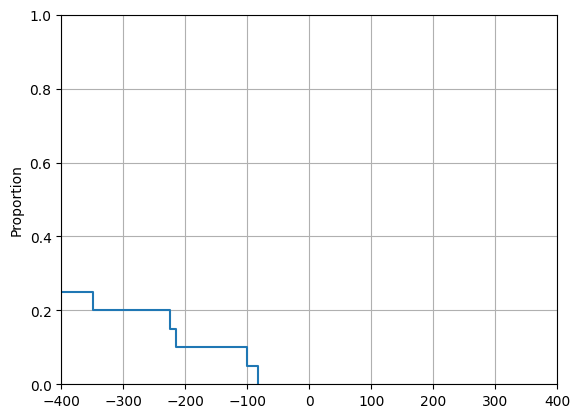

In [91]:
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=return_array, ax=ax, complementary=True)
ax.set_xlim(-400, 400)
plt.grid()

<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and

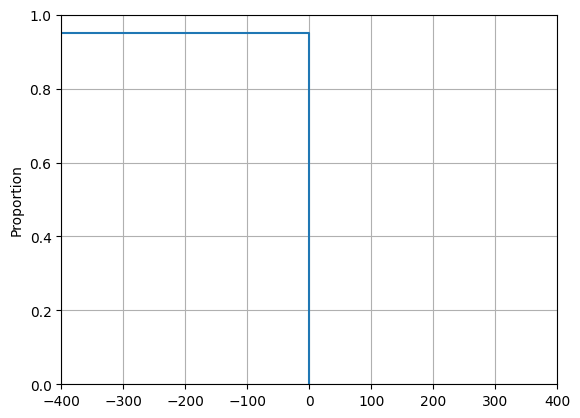

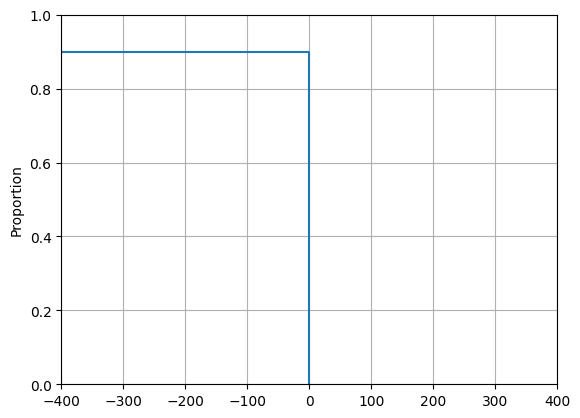

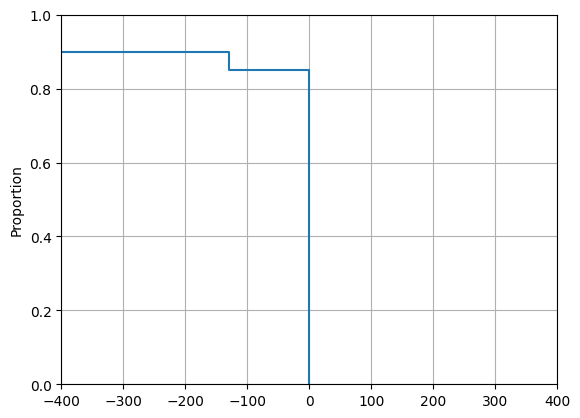

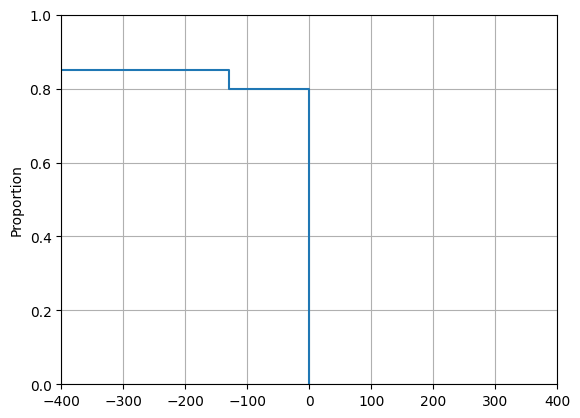

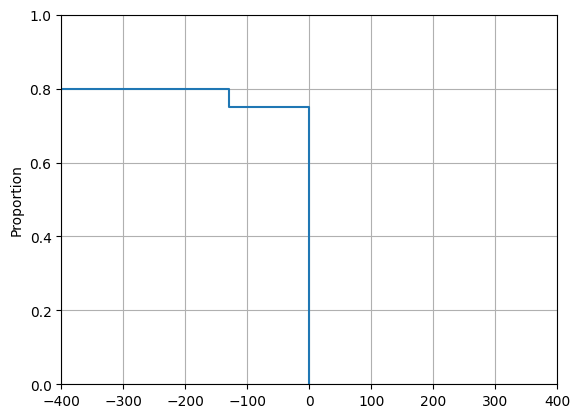

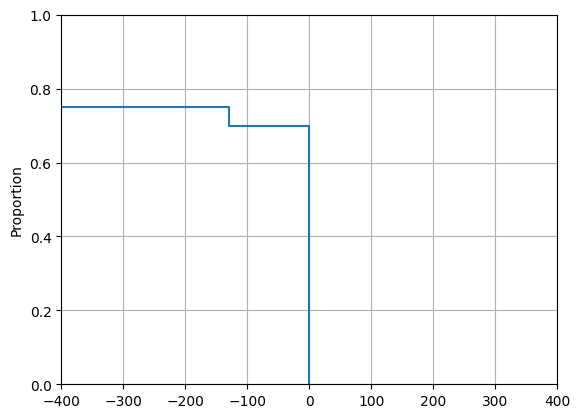

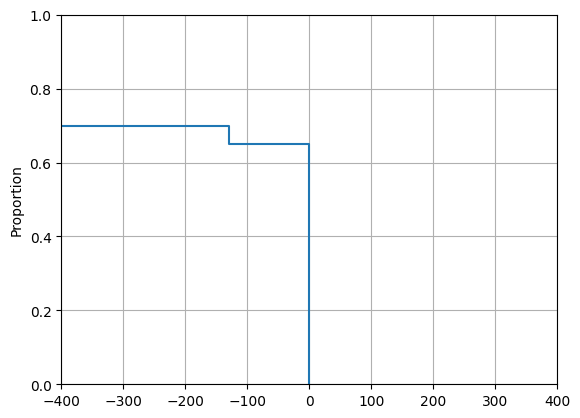

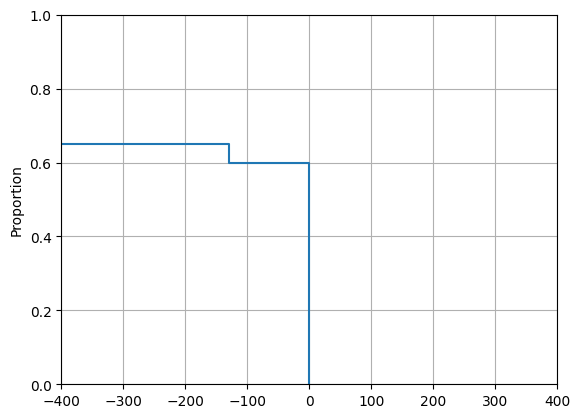

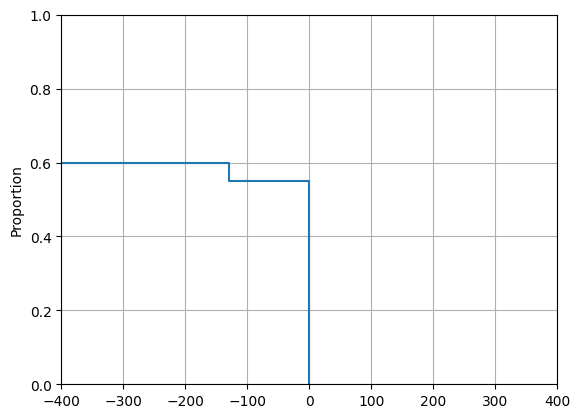

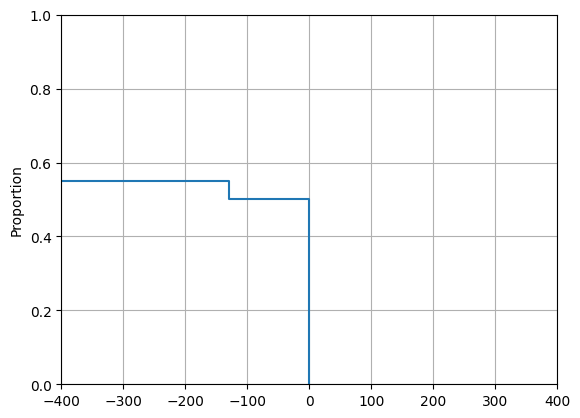

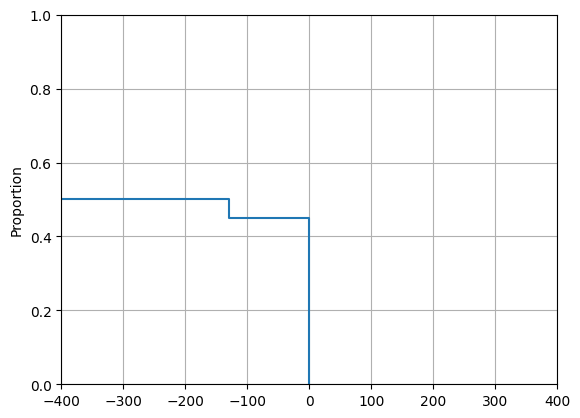

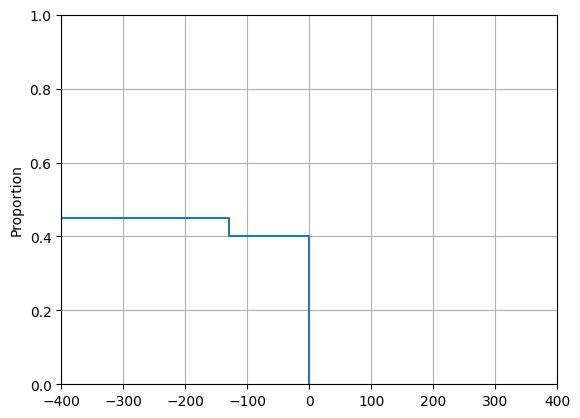

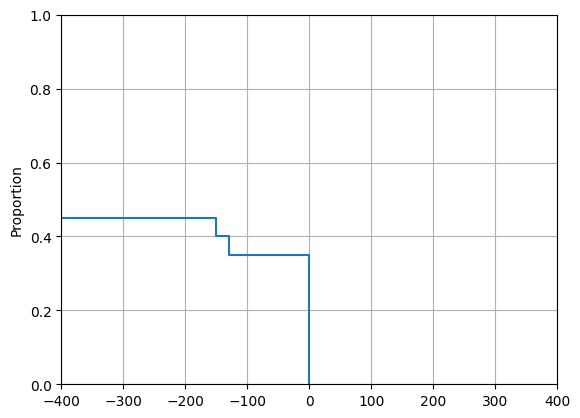

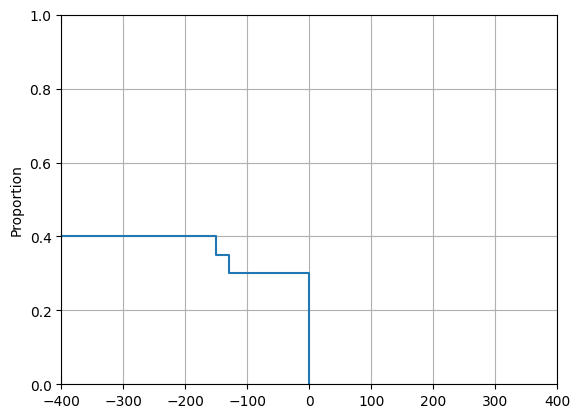

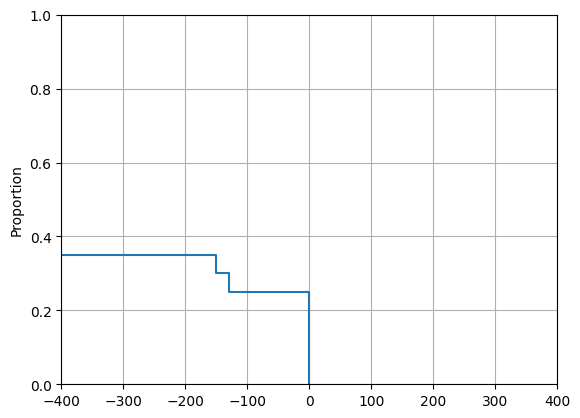

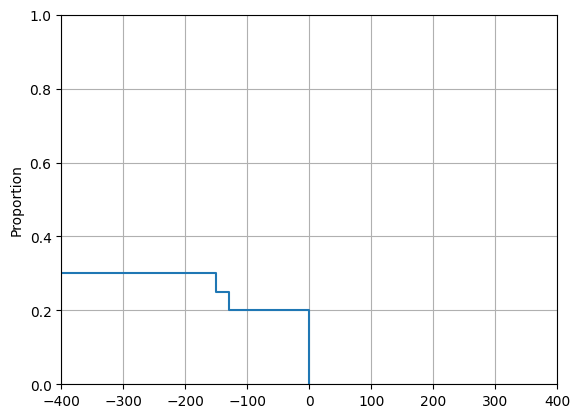

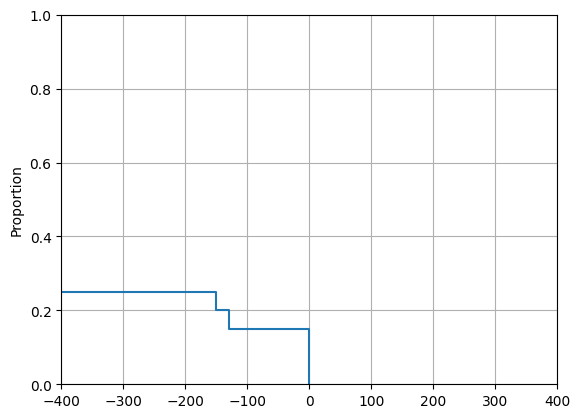

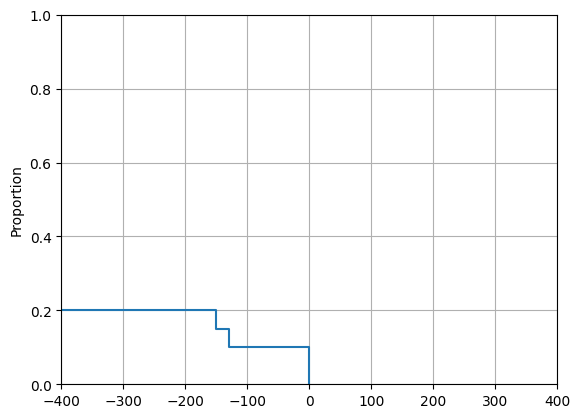

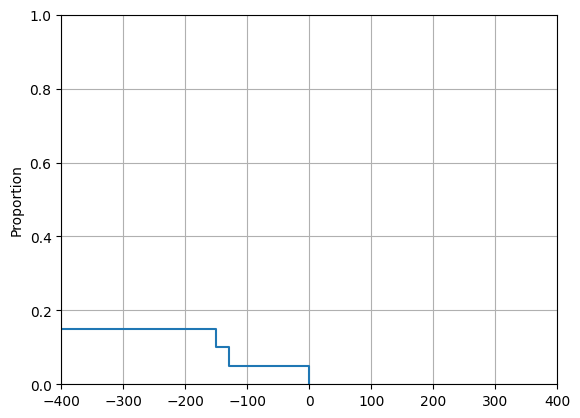

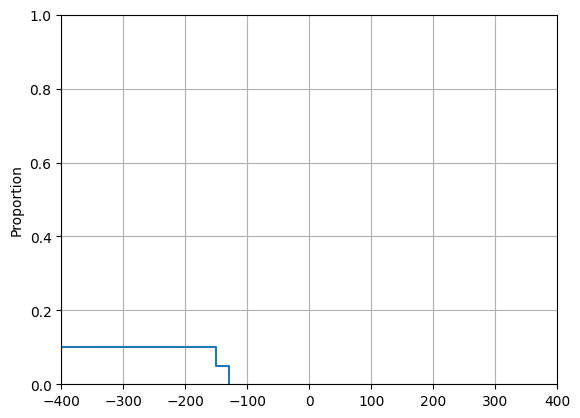

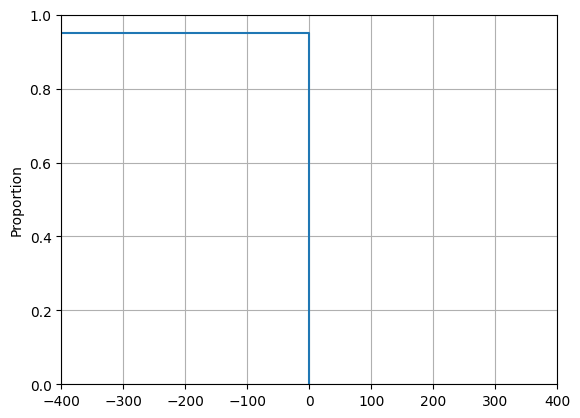

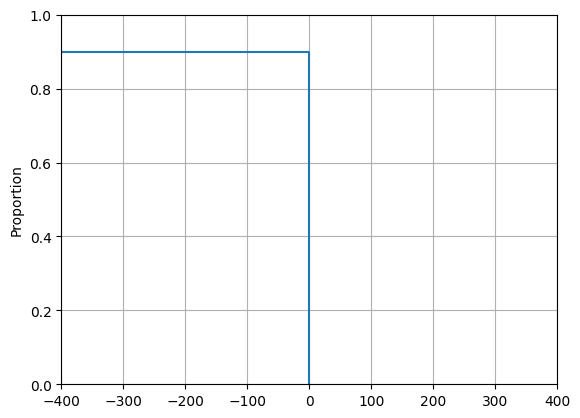

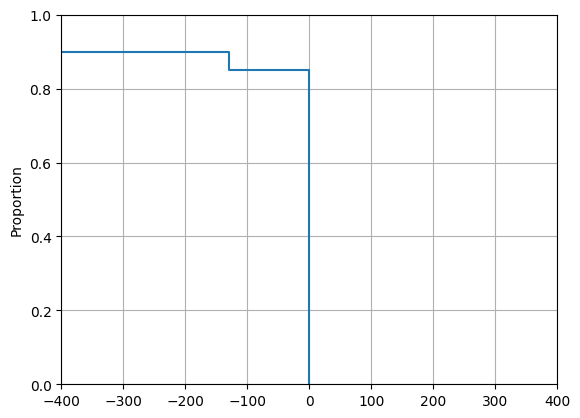

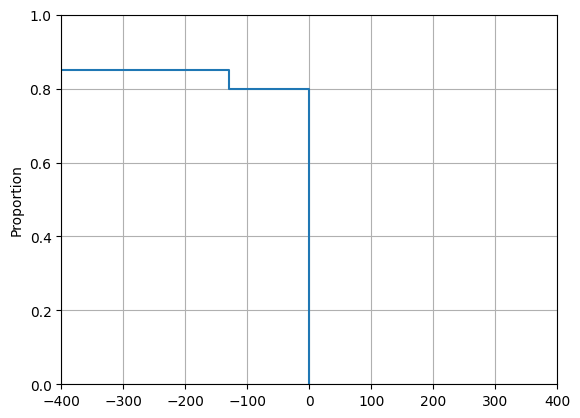

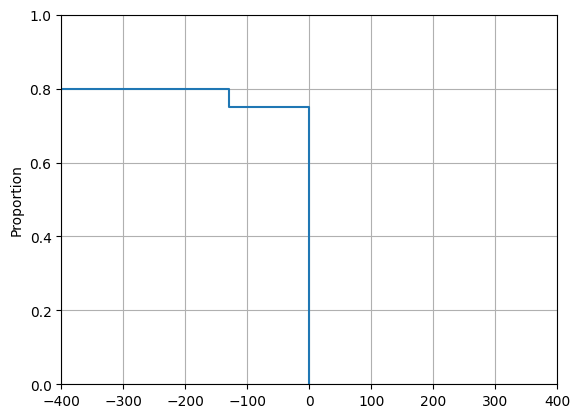

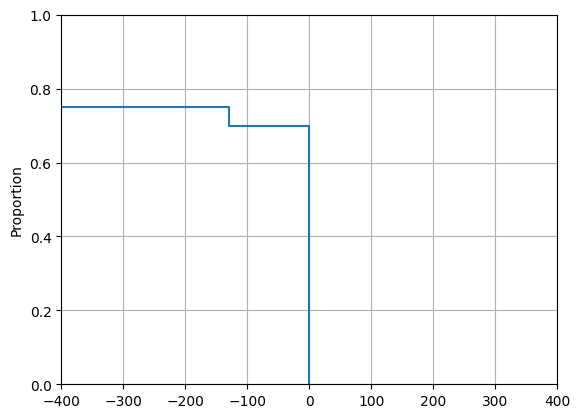

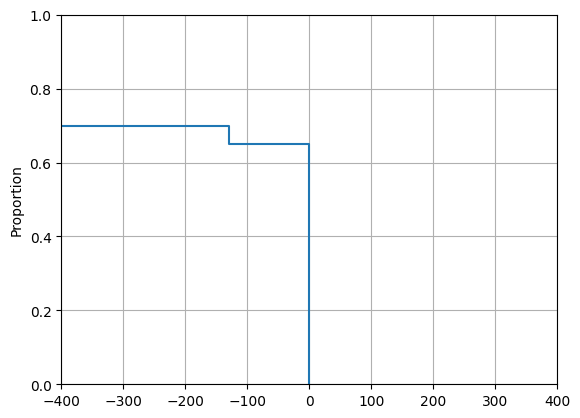

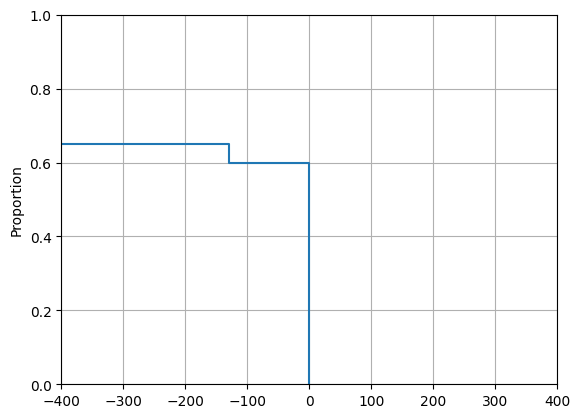

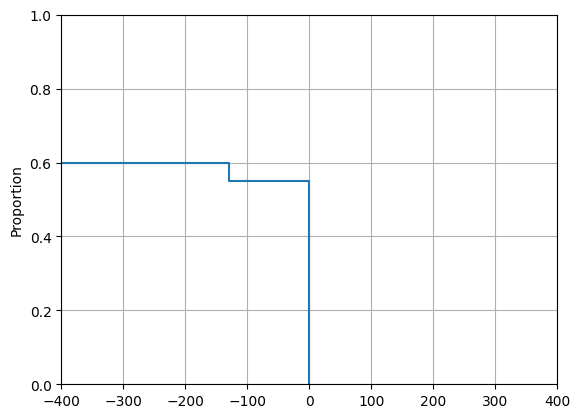

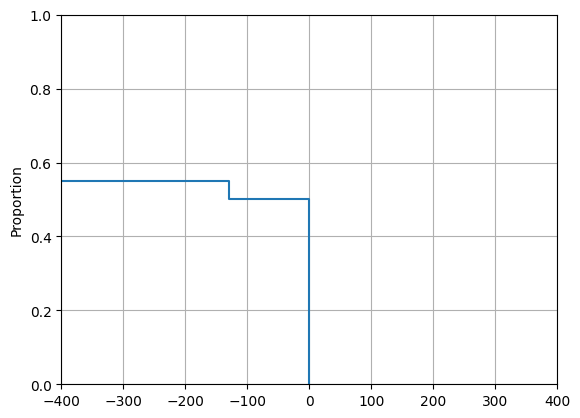

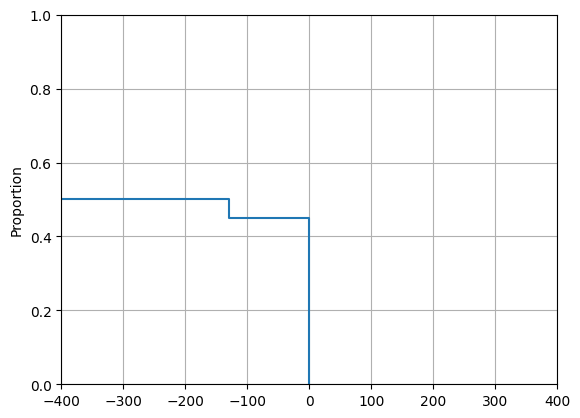

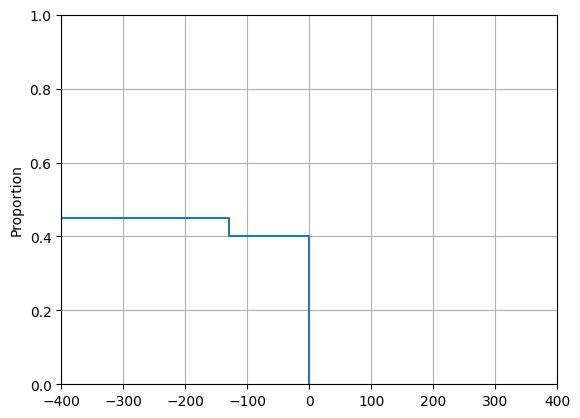

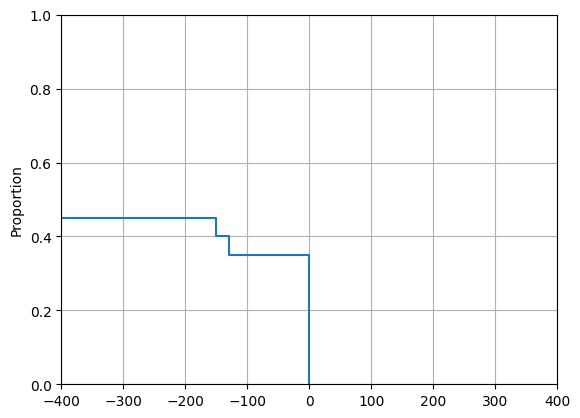

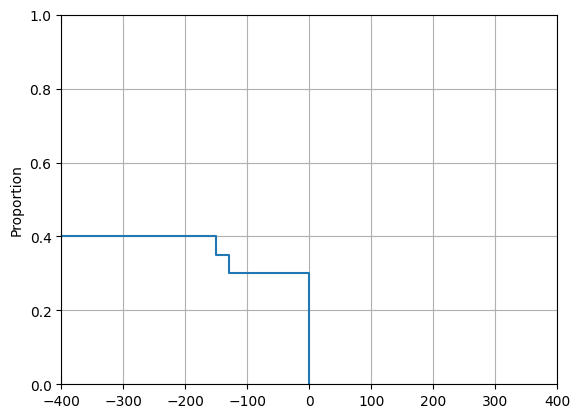

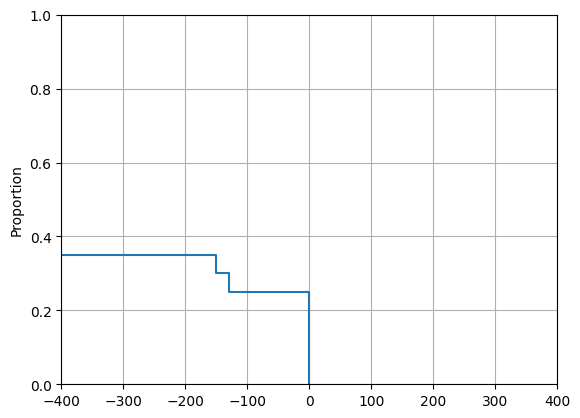

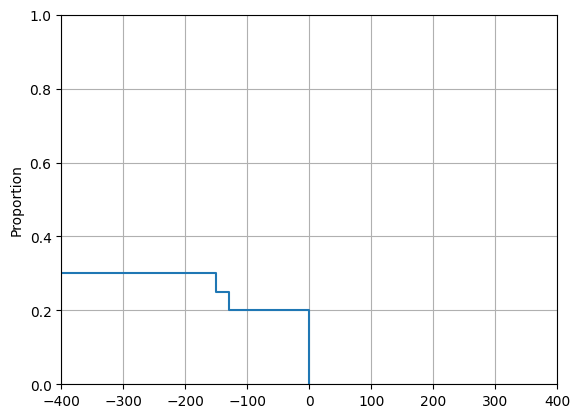

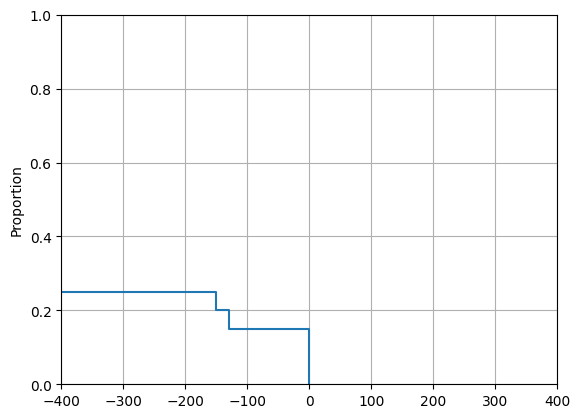

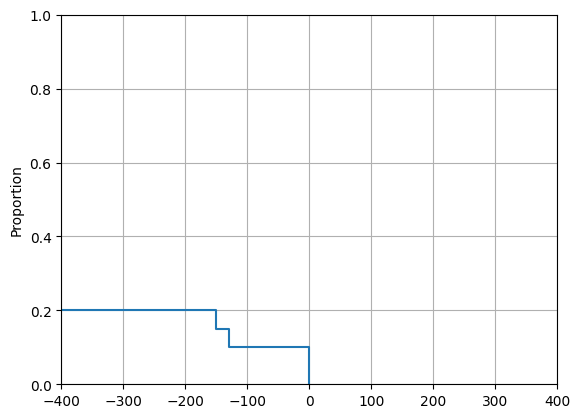

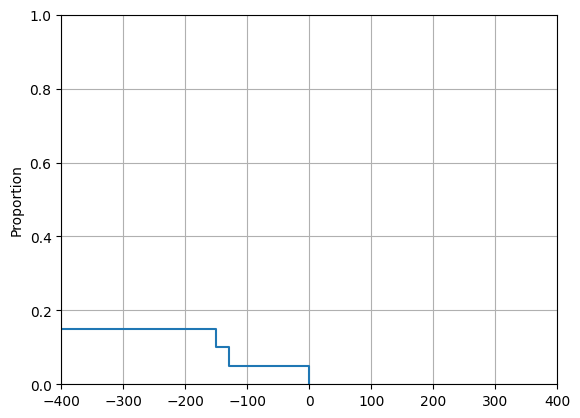

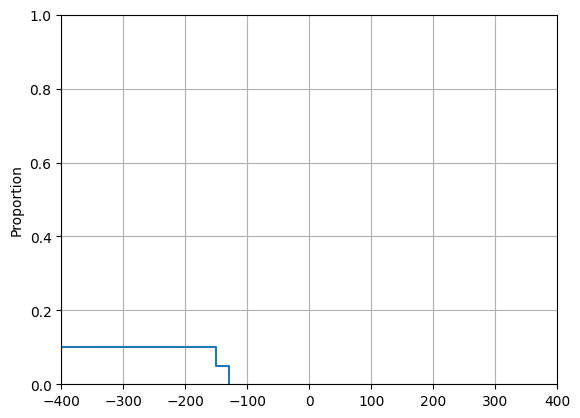

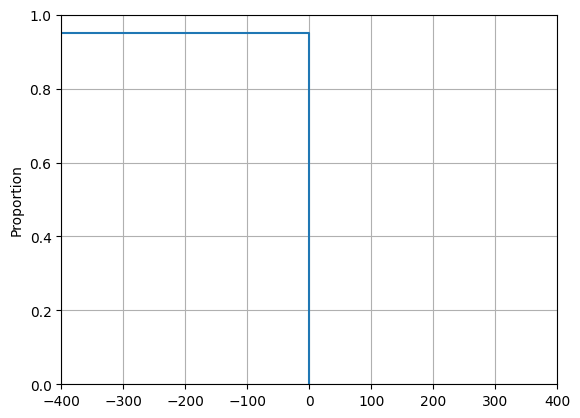

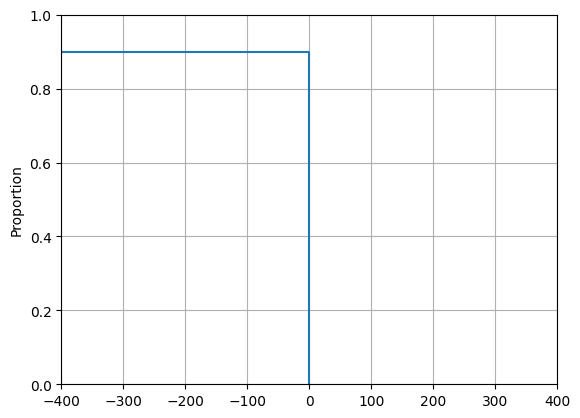

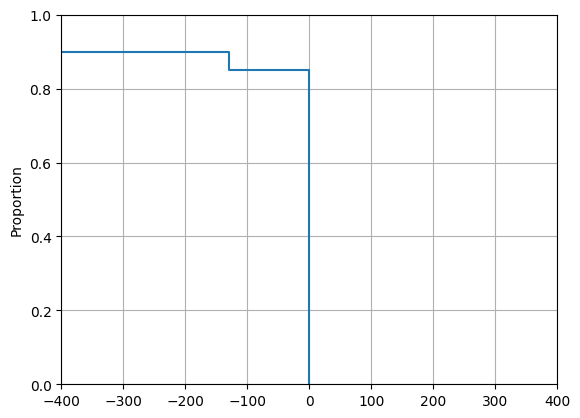

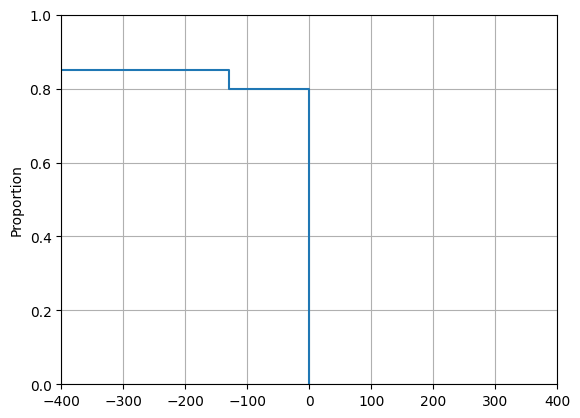

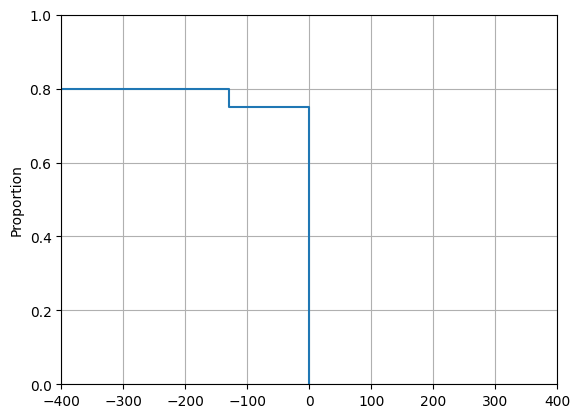

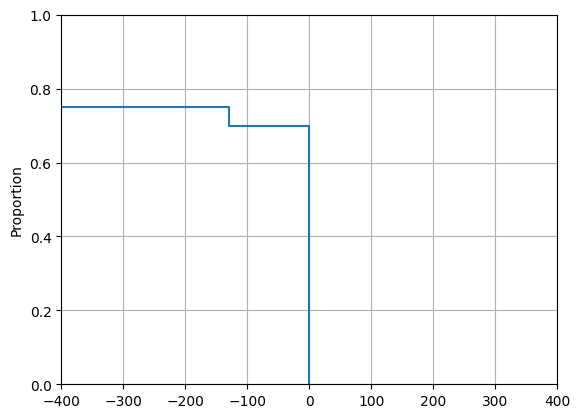

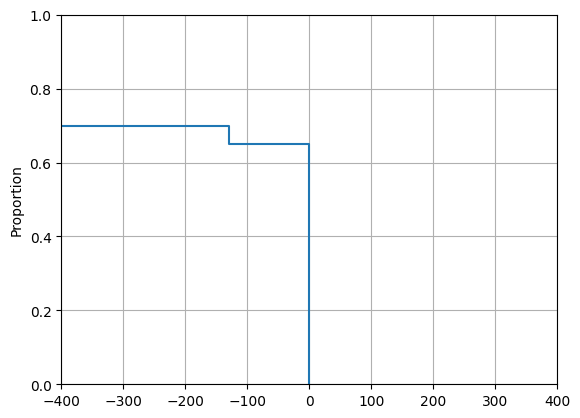

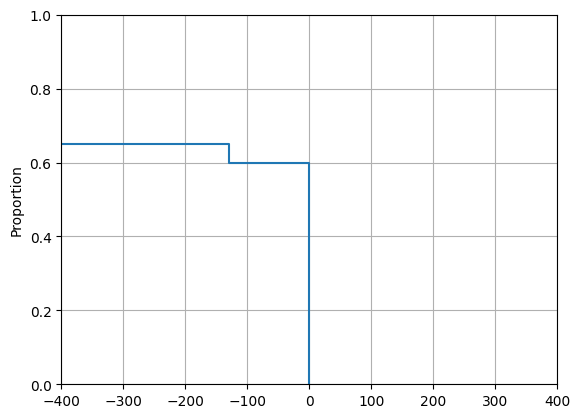

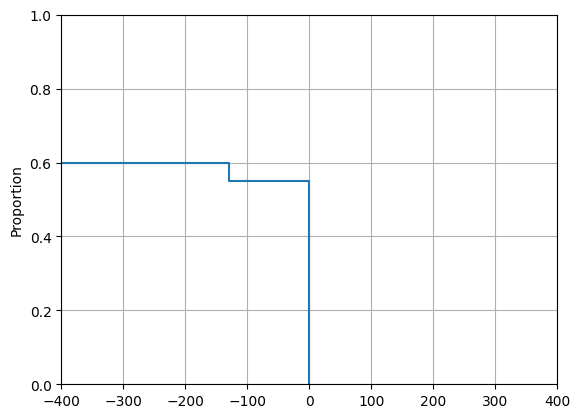

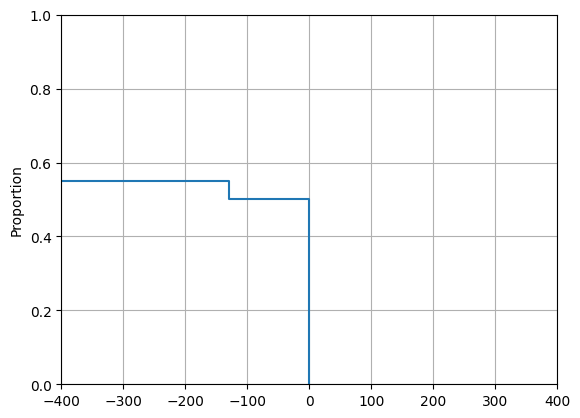

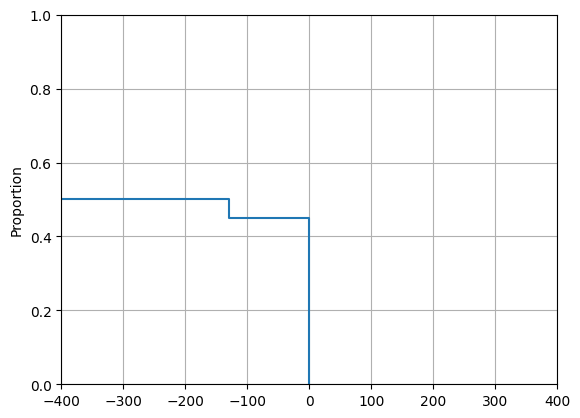

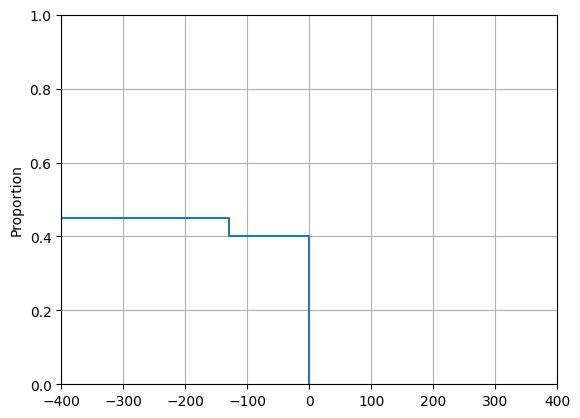

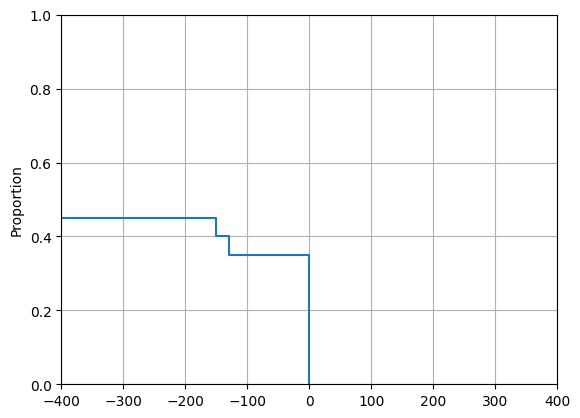

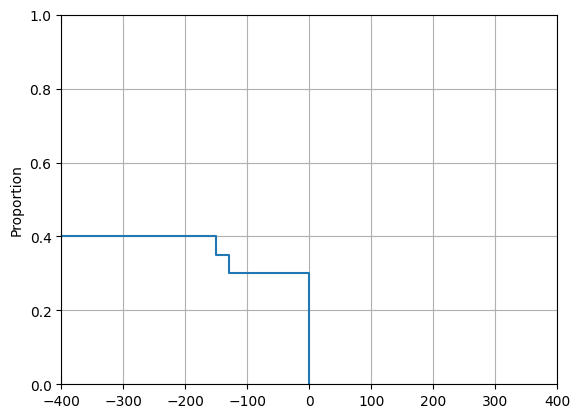

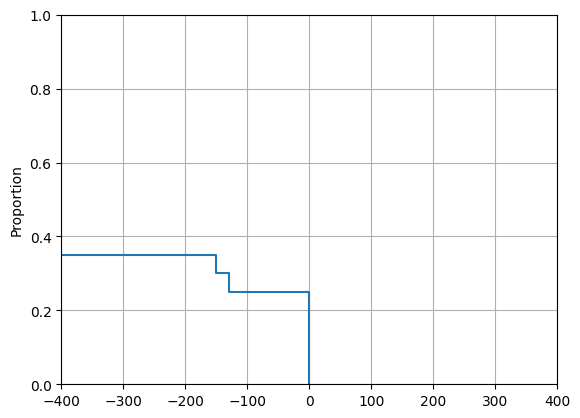

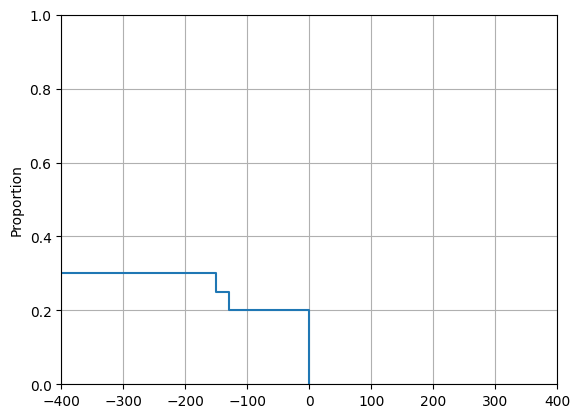

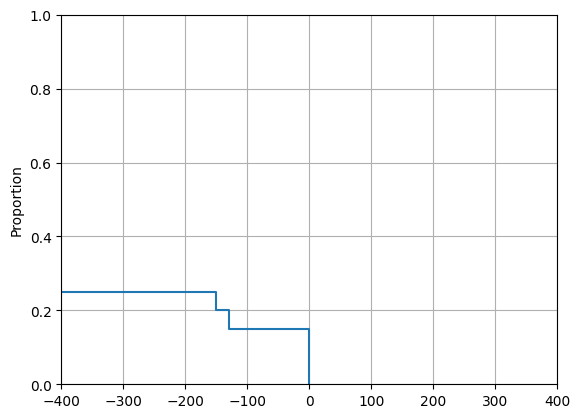

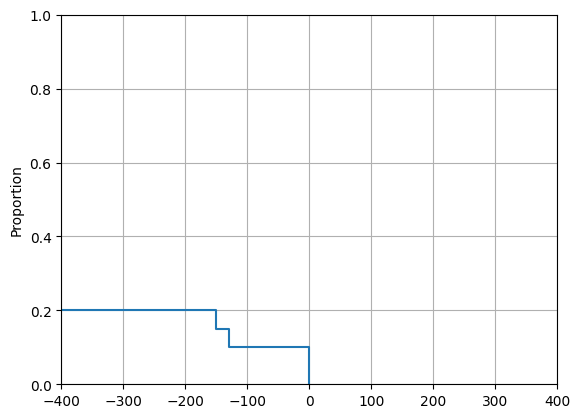

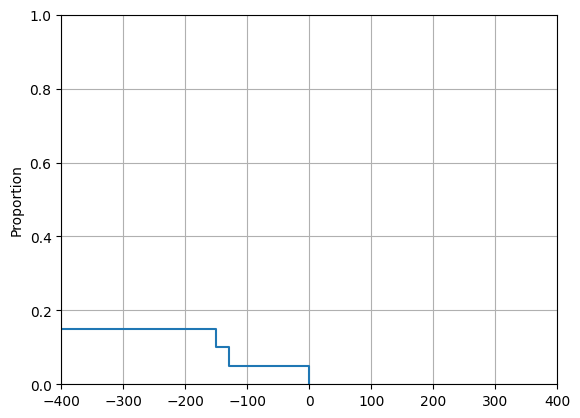

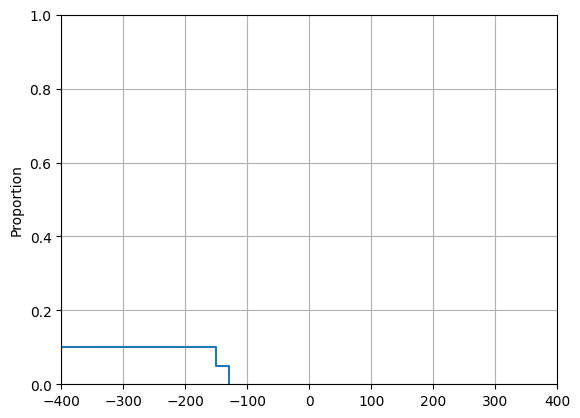

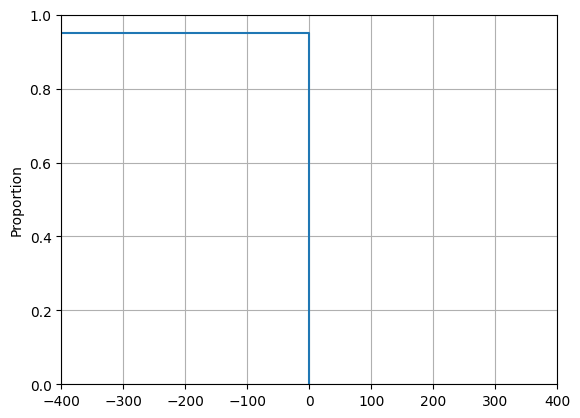

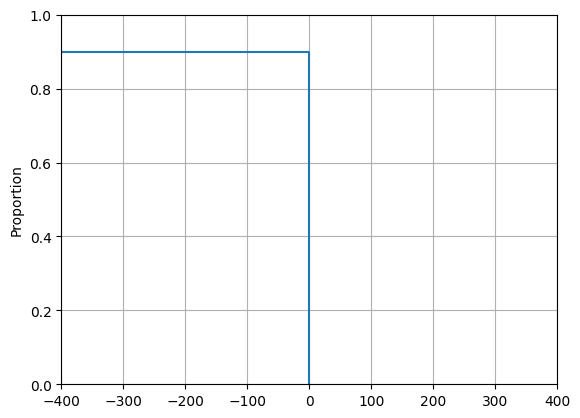

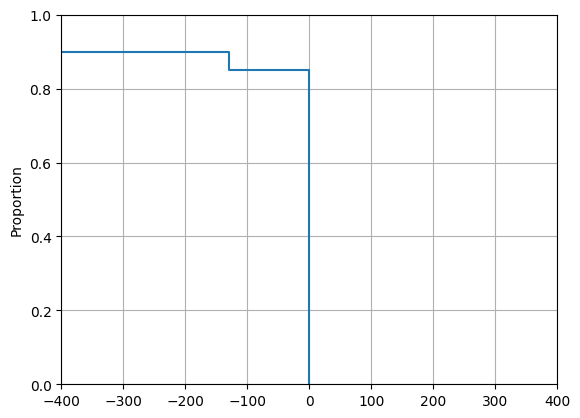

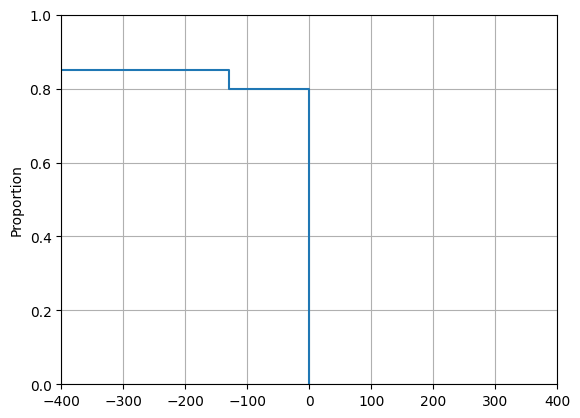

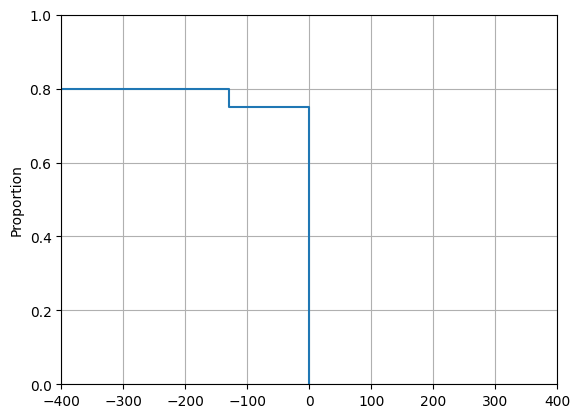

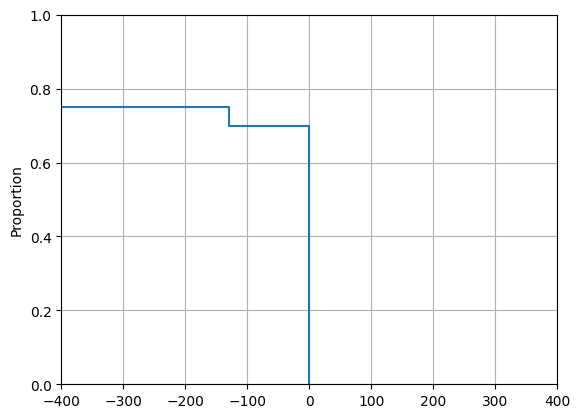

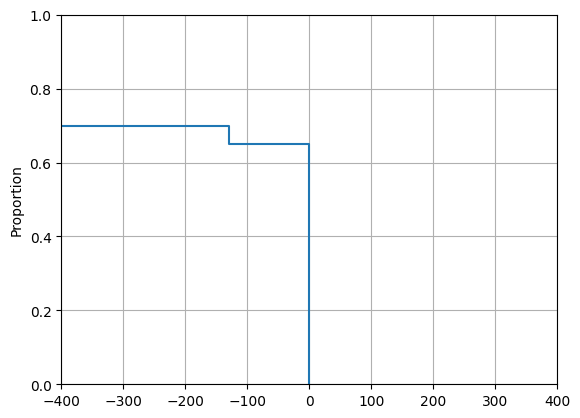

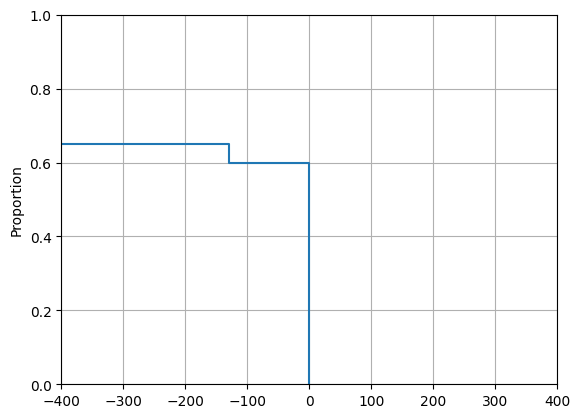

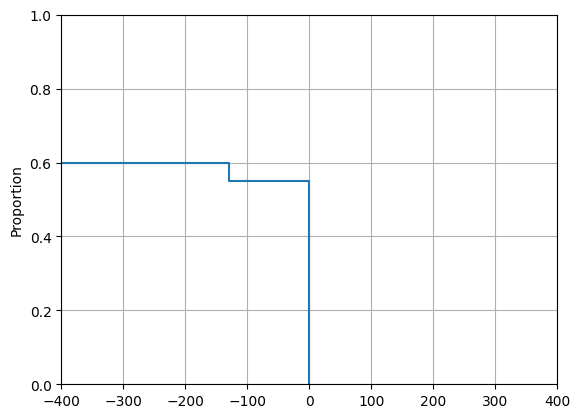

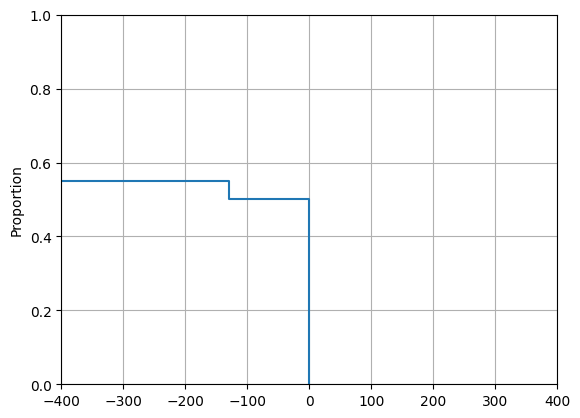

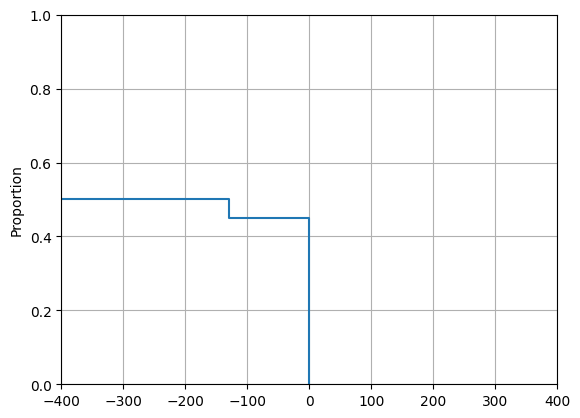

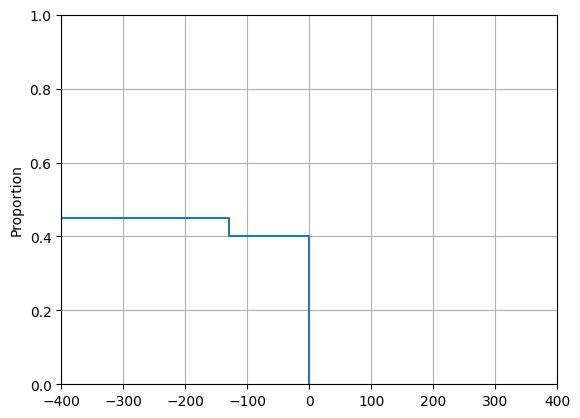

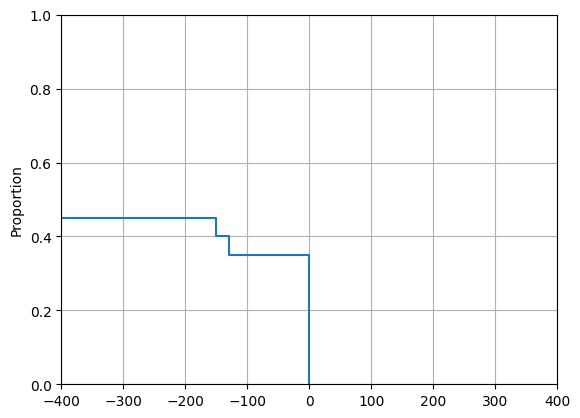

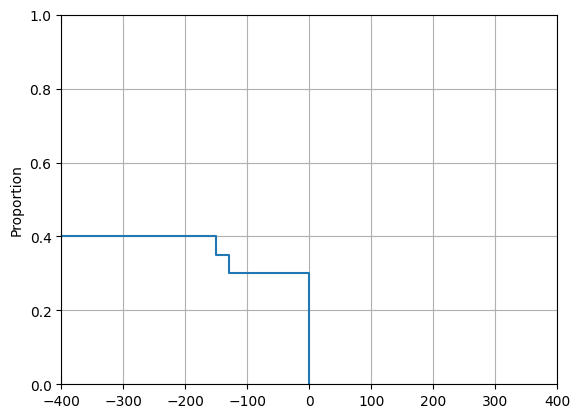

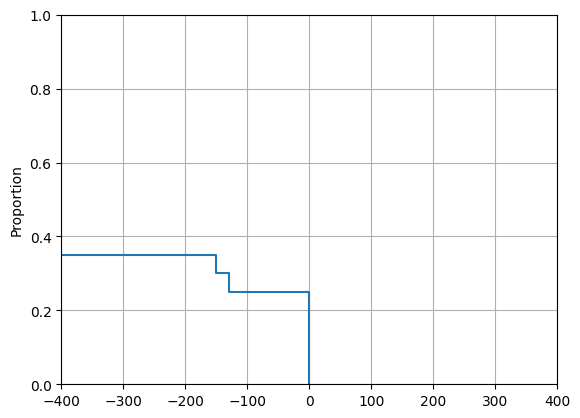

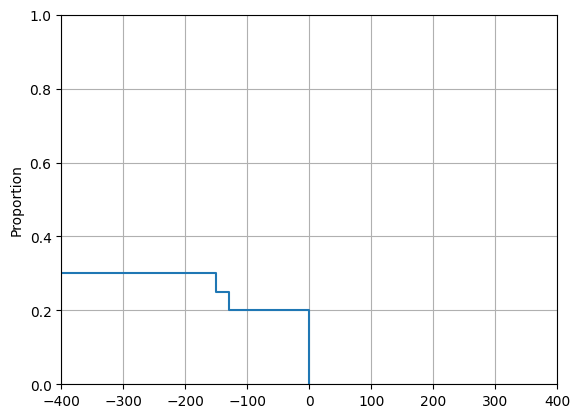

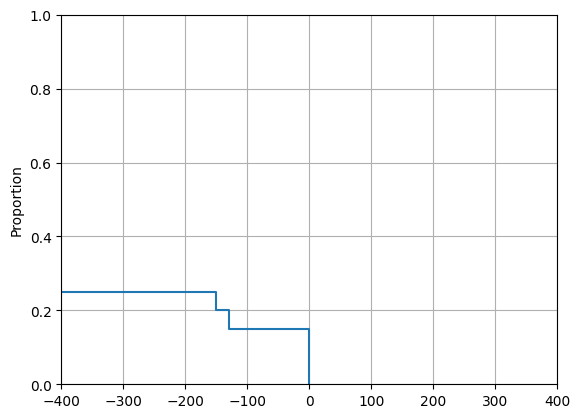

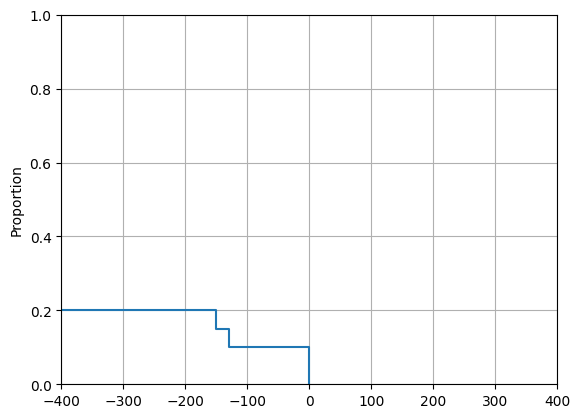

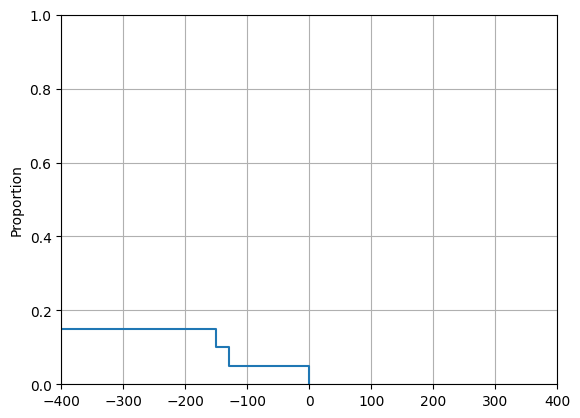

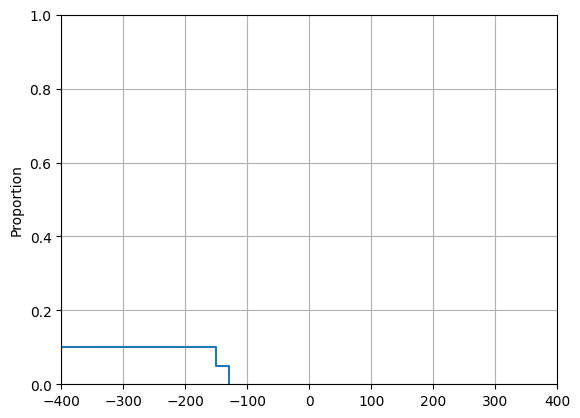

In [92]:
for e in range(max_episode):
    history, img = rollout(envname, agent.policy)
    agent.update(history)
    if (e + 1) % lr_decay_interval == 0:
        seed_array = np.arange(100, 2100, 100)
        return_array = np.zeros(len(seed_array))
        for i, seed in enumerate(seed_array):
            history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
            return_array[i] = cumulative_reward(history)

            fig, ax = plt.subplots()
            sns.ecdfplot(data=return_array, ax=ax, complementary=True)
            ax.set_xlim(-400, 400)
            plt.grid()

        agent.lr *= 0.3


<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


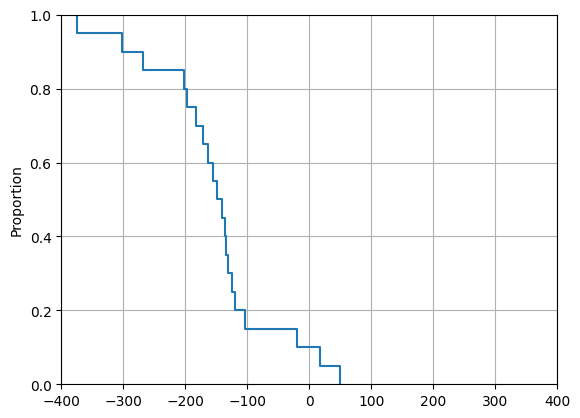

In [87]:
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=return_array, ax=ax, complementary=True)
ax.set_xlim(-400, 400)
plt.grid()

In [64]:
avg_cr = 0.0
for e in range(MAX_EPISODE):
    history, img = rollout(envname, agent.policy)
    agent.update(history)
    avg_cr += cumulative_reward(history)
    if (e + 1) % 100 == 0:
        print(1+e, avg_cr/100)
        avg_cr = 0.0

100 -2.6409090832994195
200 -3.2608444146512956
300 -1.736412142947613
400 -2.9418449572485224
500 -0.6129548914231979
600 -1.43992443093755
700 -2.248598511713945
800 -1.4470300606483313
900 -0.5504042600420508
1000 -1.023074350658569
1100 -2.069167244689957
1200 -3.713823378930463
1300 -1.0602275012180424
1400 -1.258684991693486
1500 -3.771487425237965
1600 -0.3611580172213131
1700 -1.5056072847477284
1800 -2.8757991311020192
1900 -1.4463990489870167
2000 -3.80956533263741
2100 -2.492183425842748
2200 -0.6525571773731685
2300 -1.1594187426285323
2400 -1.9029621884732189
2500 -4.101891472989271
2600 -0.6615562421050594
2700 -1.3351419007653798
2800 -1.5398523762515577
2900 -1.8620009775667647
3000 -0.8014655537261163
3100 -2.9507929803349304
3200 -1.154488871814529
3300 -1.0728191361593529
3400 -1.3031035322866429
3500 -1.5209262508856631
3600 -2.3886981111548873
3700 -0.8126813068512722
3800 -1.9345008669205321
3900 -1.9659117668898745
4000 -0.9630210452760223
4100 -2.192383620323489

<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


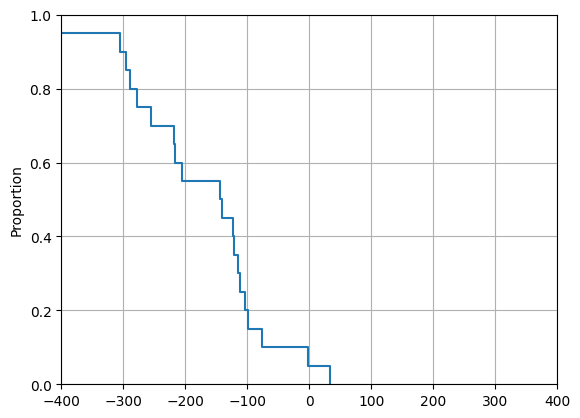

In [65]:
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=return_array, ax=ax, complementary=True)
ax.set_xlim(-400, 400)
plt.grid()

In [67]:
history, img = rollout(envname, policy=agent.policy, render=True)
print(cumulative_reward(history))
visualize(img)

-250.40824657549953



行動価値関数に着目しましょう．
今，行動価値関数を近似する関数$q^\pi(s, a)$を持っているとしましょう．
これを更新して，真の行動価値$Q^{\pi}(s, a)$に近づけることを考えます．
行動価値$Q^{\pi}(s, a)$の満たす再帰式
$$
Q^{\pi}(s, a) = \mathrm{E}[r_{t+1} + \gamma Q^{\pi}(s_{t+1}, a') \mid s_t = s, a' \sim \pi(\cdot\mid s_{t+1})]
$$
を，$q^\pi(s, a)$も満たすように更新していきます．
この際，右辺の期待値は計算できませんが，実際に観測された値を用いて近似すれば，
右辺は
$$
r_{t+1} + \gamma Q^{\pi}(s_{t+1}, a')
$$
となります．ここで，$a' \sim \pi(\cdot\mid s_{t+1})$です．
右辺の$Q^{\pi}$を$q^\pi(s, a)$で置き換えたものを
$$
y = r_{t+1} + \gamma q^{\pi}(s_{t+1}, a')
$$
とします．
再帰式を満たすように，$q^{\pi}(s, a)$が$y$に近づくように$q^{\pi}$を更新します．
$q^{\pi}$がパラメータ$w$を用いてモデル化されているならば，
$$
w \leftarrow w - \frac{\alpha_w}{2}\nabla_w (q^{\pi}(s, a) - y)^2 = w -  \alpha_w (q^{\pi}(s, a) - y) \nabla_w q^{\pi}(s, a)
$$
などと更新します．ここで，$\alpha_w$は学習率を表します．

## 使用環境：Lunar Lander（連続状態，離散行動）


In [ ]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym
from IPython import display

In [ ]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []
    if seed is not None:
        random.seed(seed)
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)
    if render:
        d = Display()
        d.start()
        img.append(env.render())
    terminated = False
    truncated = False
    while not (terminated or truncated):
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
w = np.random.randn(num_action, dim_state)
b = np.random.randn(num_action)
policy = SoftmaxPolicy(w, b)
history, img = rollout(envname, policy, render=True)
visualize(img)

In [ ]:
cumulative_reward(history)

In [ ]:
class ES:
    def __init__(self, init_s, init_x, init_fx):
        self.fx = init_fx
        self.x = np.array(init_x, copy=True)
        self.s = init_s
        self.dim = len(self.x)
        self.alpha = np.exp(1.0 / self.dim)
        self.y = np.empty(self.dim)

    def ask(self):
        self.y = self.x + self.s * np.random.randn(self.dim)
        return self.y

    def tell(self, fx):
        if self.fx < fx:
            self.s /= self.alpha**(0.25)
        else:
            self.s *= self.alpha
            self.x = self.y
            self.fx = fx

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)


def objective(x):
    w, b = SoftmaxPolicy.x2wb(x)
    policy = SoftmaxPolicy(w, b)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history)


sigma = 1.0
mean = np.zeros(dim_x)
f_hist = np.empty(2000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])

In [ ]:
plt.plot(f_hist)

In [ ]:
policy = SoftmaxPolicy(*SoftmaxPolicy.x2wb(es.x))
history, img = rollout(envname, policy, seed=100, render=True)
visualize(img)
cumulative_reward(history)

In [ ]:
class MultiLayerSoftmaxPolicy:
    def __init__(self, dim_array):
        self.w_list = []
        self.b_list = []
        self.dim_array = dim_array
        for i in range(len(dim_array)-1):
            self.w_list.append(np.zeros((dim_array[i+1], dim_array[i])))
            self.b_list.append(np.zeros(dim_array[i+1]))

    def __call__(self, observation):
        z = np.array(observation, copy=True)
        for i in range(len(self.dim_array)-2):
            z = np.dot(self.w_list[i], z) + self.b_list[i]
            z = np.fmax(z, 0)
        z = np.dot(self.w_list[-1], z) + self.b_list[-1]
        prob = softmax(z)
        return random.choices(list(range(len(prob))), prob)[0]

    def set_param(self, x):
        n = 0
        for i in range(len(self.dim_array)-1):
            dim1 = self.dim_array[i+1]
            dim0 = self.dim_array[i]
            self.w_list[i] = x[n:n + dim1 * dim0].reshape((dim1, dim0))
            self.b_list[i] = x[n + dim1 * dim0:n + dim1 * (dim0 + 1)]
            n += dim1 * (dim0 + 1)
        # dim1 = self.dim_array[-1] - 1
        # dim0 = self.dim_array[-2]
        # self.w_list[-1][1:, :] = x[n:n + dim1 * dim0].reshape((dim1, dim0))
        # self.b_list[-1][1:] = x[n + dim1 * dim0:n + dim1 * (dim0 + 1)]

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_array = [8, 20, 20, 4]
dim_x = 0
for i in range(len(dim_array) - 1):
    dim1 = dim_array[i+1]
    # if i == len(dim_array) - 1:
    #     dim1 -= 1
    dim0 = dim_array[i]
    dim_x += dim1 * (dim0 + 1)

def objective(x):
    policy = MultiLayerSoftmaxPolicy(dim_array)
    policy.set_param(x)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history) + 1e-2 * np.dot(x, x)

sigma = 0.1
mean = sigma * np.random.randn(dim_x)
f_hist = np.empty(10000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])


In [ ]:
plt.plot(f_hist)

In [ ]:
policy = MultiLayerSoftmaxPolicy(dim_array)
policy.set_param(es.x)
history, img = rollout(envname, policy, seed=100, render=True)
visualize(img)
cumulative_reward(history)

In [ ]:
policy = MultiLayerSoftmaxPolicy(dim_array)
policy.set_param(es.x)
history, img = rollout(envname, policy, seed=None)
cumulative_reward(history)